# Time Series Analysis

In [1]:
#import libraries
import numpy as np
import pandas as pd

import yfinance as yf
from yahoofinancials import YahooFinancials

#importing required libraries for ARIMA, auto_Arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

from math import sqrt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

#importing libraries for Exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

from pandas.tseries.offsets import DateOffset

#data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
plt.style.use('seaborn')
import cufflinks as cf



# figure will appear below the cell that generated it
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #improve plot visualisation

import warnings
warnings.filterwarnings("ignore") #is a built-in module of Python that handles the warning messages

In [2]:
#download market data using yfinance API

stock_data = yf.download(tickers = 'JPM C GS MS UBS BCS', period = '4y',
                  interval = '1d', actions = 'inline')

#actions = 'inline' #additionally download dividends and stock splits

[*********************100%***********************]  6 of 6 completed


# Part I

In this part of my project, I will perform an exploratory data analysis of investment banks like J.P Morgan, Goldman Sachs, Citigroup, Morgan Stanley, UBS, and Barclays. Visualize daily traded volume, volatility, and Market Capitalisation.

Data description:
* Open: The price of the stock when the market opens in the morning
* Close: The price of the stock when the market closed in the evening
* High: Highest price the stock reached during that day
* Low: Lowest price the stock is traded on that day
* Volume: The total amount of stocks traded on that day

In [3]:
#check for missing data
stocks_adj_close_price = stock_data['Adj Close'].copy()
stocks_adj_close_price.isnull().sum()

BCS    0
C      0
GS     0
JPM    0
MS     0
UBS    0
dtype: int64

In [4]:
#In case there are missing data I choose 'bfill' method such as the next stock price is always dependent on a previous value
#stocks_adj_close_price.fillna(method='bfill')

In [5]:
stocks_adj_close_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2018-05-24 to 2022-05-24
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BCS     1008 non-null   float64
 1   C       1008 non-null   float64
 2   GS      1008 non-null   float64
 3   JPM     1008 non-null   float64
 4   MS      1008 non-null   float64
 5   UBS     1008 non-null   float64
dtypes: float64(6)
memory usage: 55.1 KB


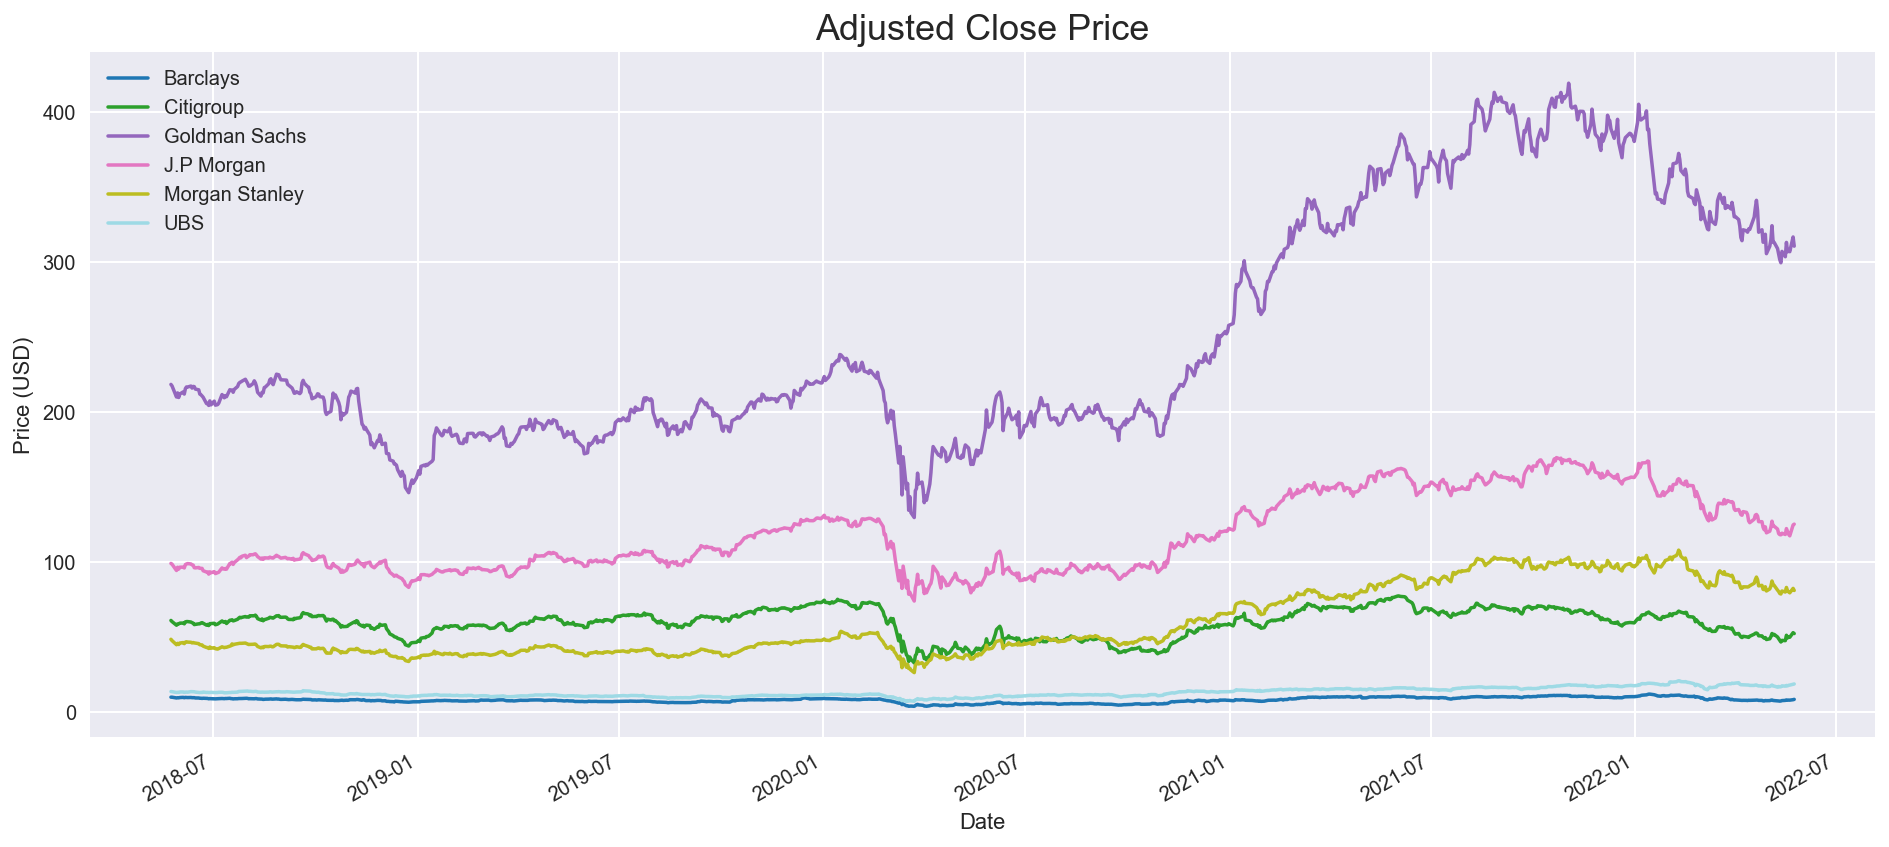

In [6]:
#rename columns
stocks_adj_close_price.rename(columns = {
    'BCS': 'Barclays', 'C': 'Citigroup', 
    'GS': 'Goldman Sachs', 'MS': 'Morgan Stanley',
    'JPM': 'J.P Morgan'},inplace = True)
#visualize
stocks_adj_close_price.plot(figsize = (16,7), colormap = 'tab20')
plt.title('Adjusted Close Price', fontdict = {'fontsize': 18})
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

We can observe that the absolute prices of Goldman Sachs are higher when comparing it to other investment banks. 

In [7]:
#summary statistics
stocks_adj_close_price.describe().round(2)


Barclays  Citigroup  Goldman Sachs  J.P Morgan  Morgan Stanley      UBS
count   1008.00    1008.00        1008.00     1008.00         1008.00  1008.00
mean       7.88      59.24         251.97      117.99           59.26    12.94
std        1.72       9.31          78.88       25.30           23.03     2.90
min        3.69      32.63         129.55       73.88           26.13     6.83
25%        6.88      54.36         192.32       96.39           40.64    10.68
50%        7.85      60.48         212.28      107.19           46.93    11.78
75%        9.30      66.16         328.37      144.05           81.74    15.17
max       11.82      77.29         419.15      169.50          107.80    20.72

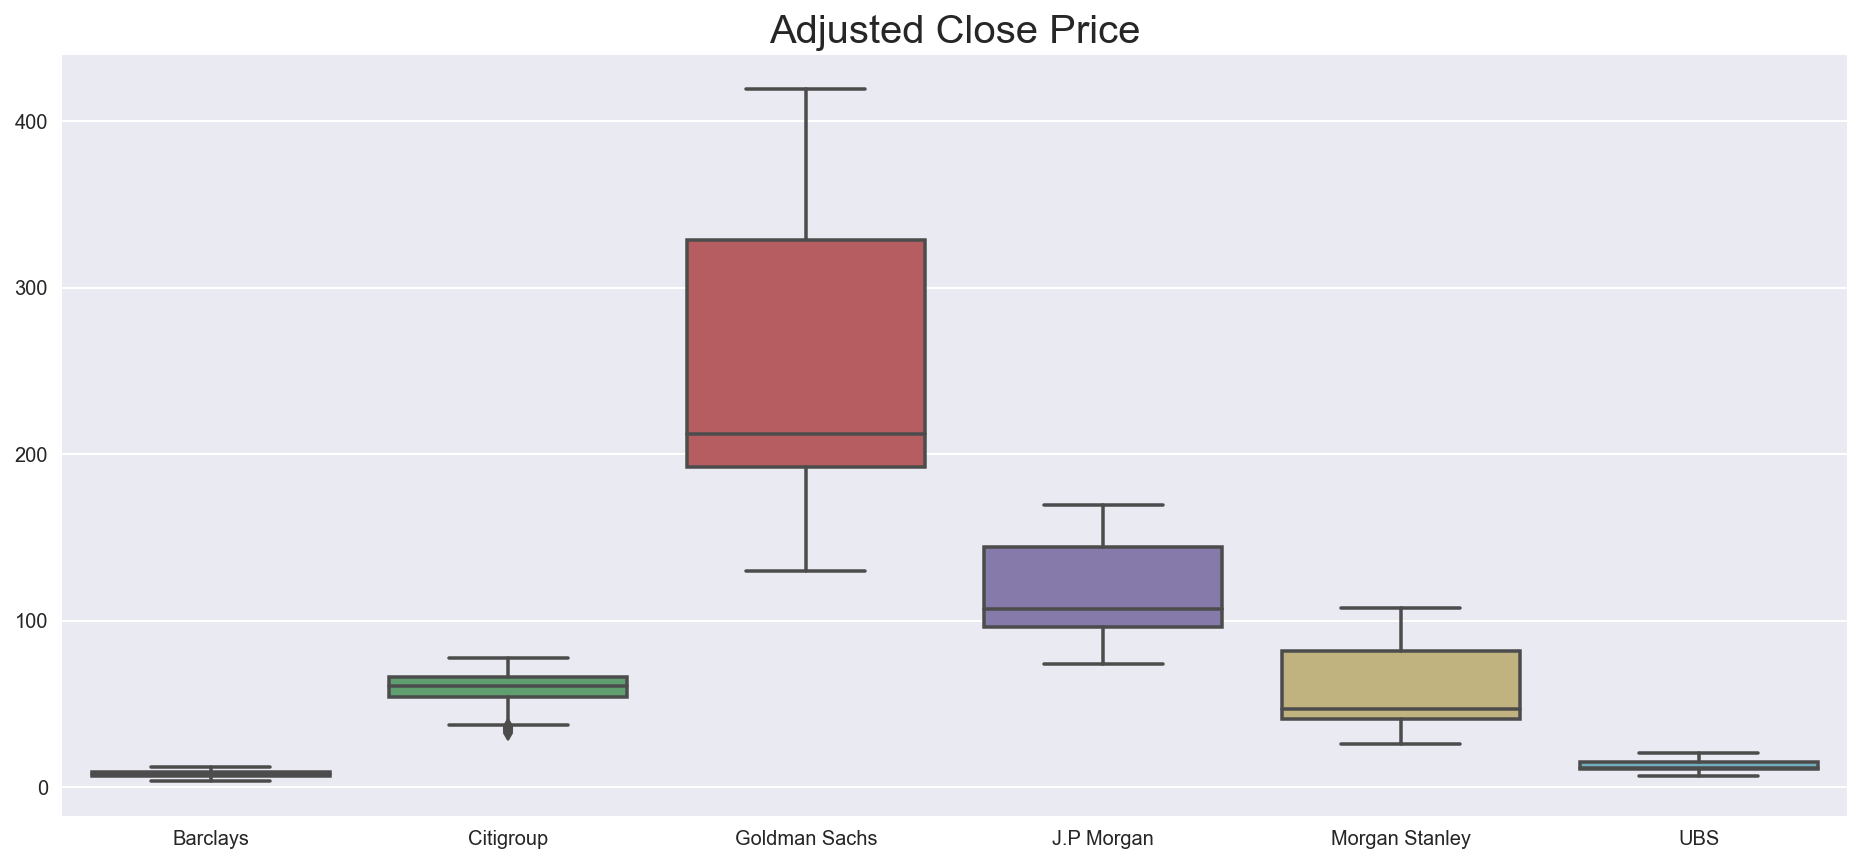

In [8]:
plt.figure(figsize = (16,7))
sns.boxplot(data = stocks_adj_close_price)
plt.title('Adjusted Close Price', fontdict={'fontsize': 20});

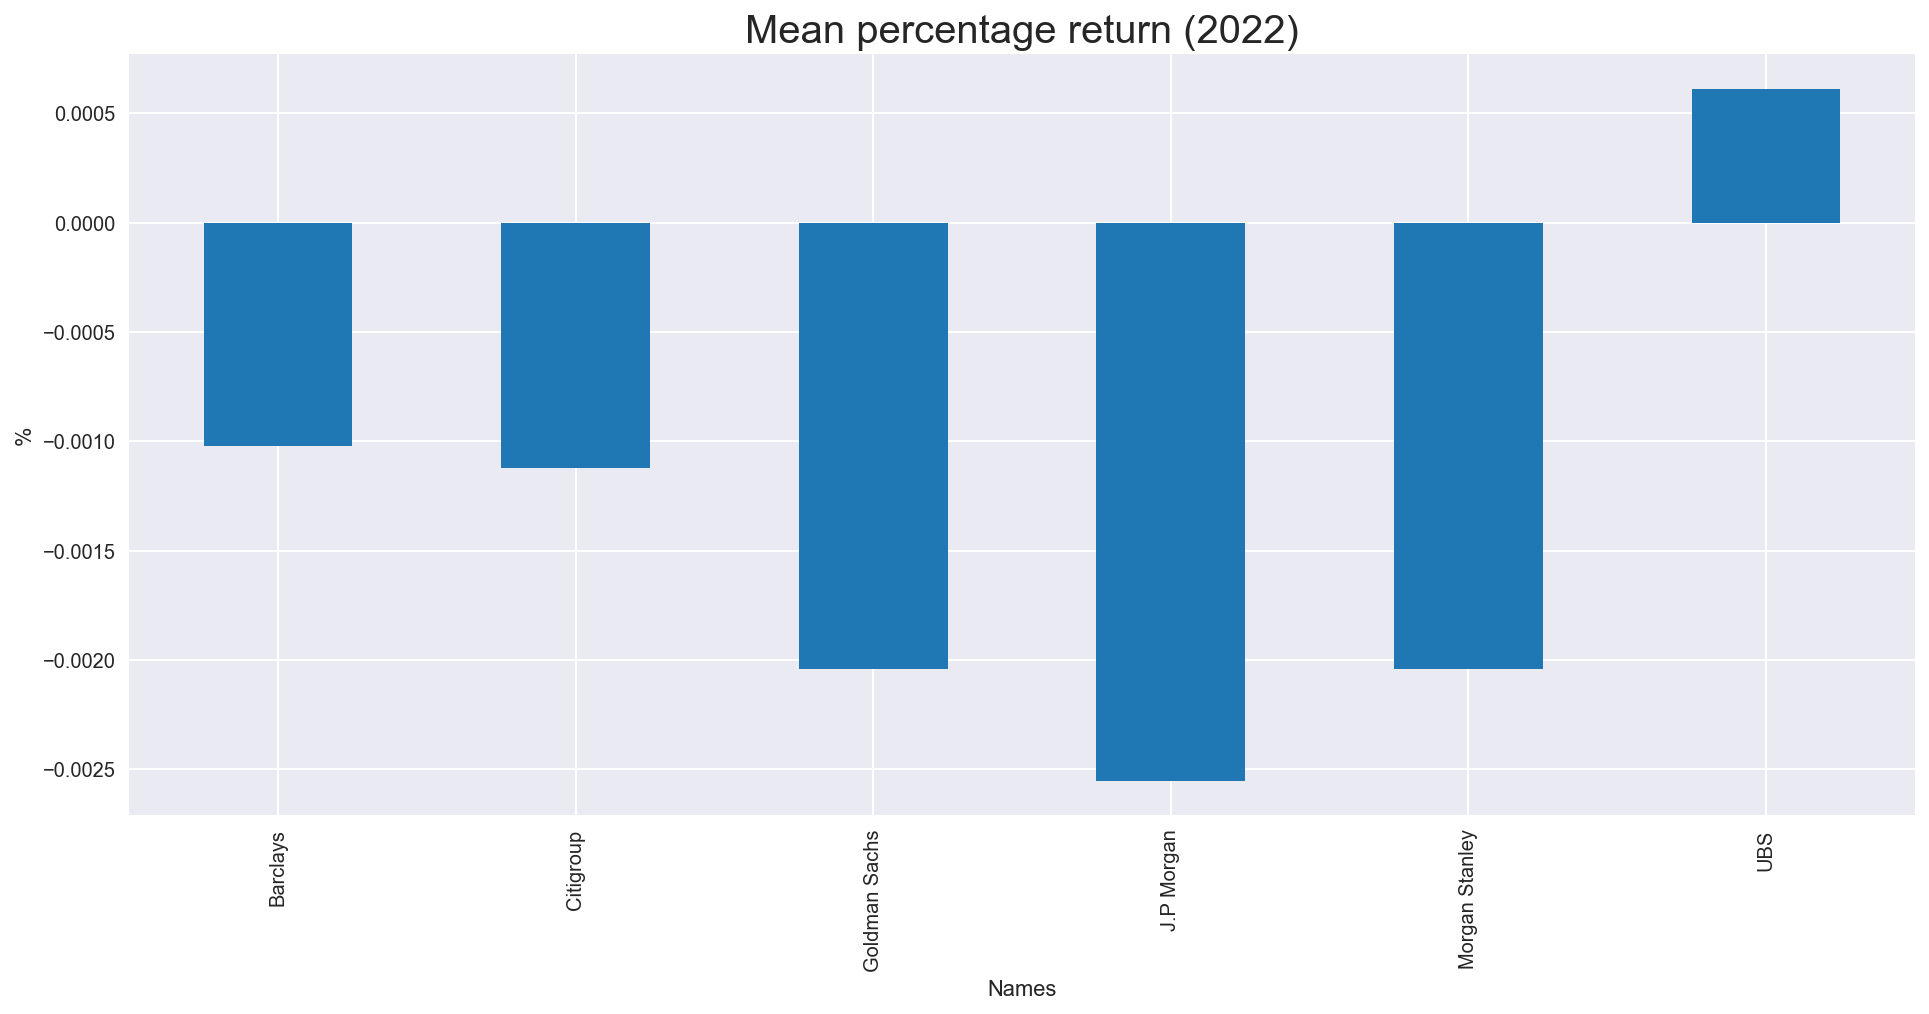

In [9]:
stocks_adj_close_price.loc['2022-01-01':].pct_change().round(2).mean().plot(kind = 'bar', figsize = (16,7), colormap = 'tab20')
plt.title('Mean percentage return (2022)',fontdict = {'fontsize': 20})
plt.xlabel('Names')
plt.ylabel('%');

It is better to calculate return on adjusted price as it reflects that stock's value after accounting for corporate actions like dividend-paying and stock splits.

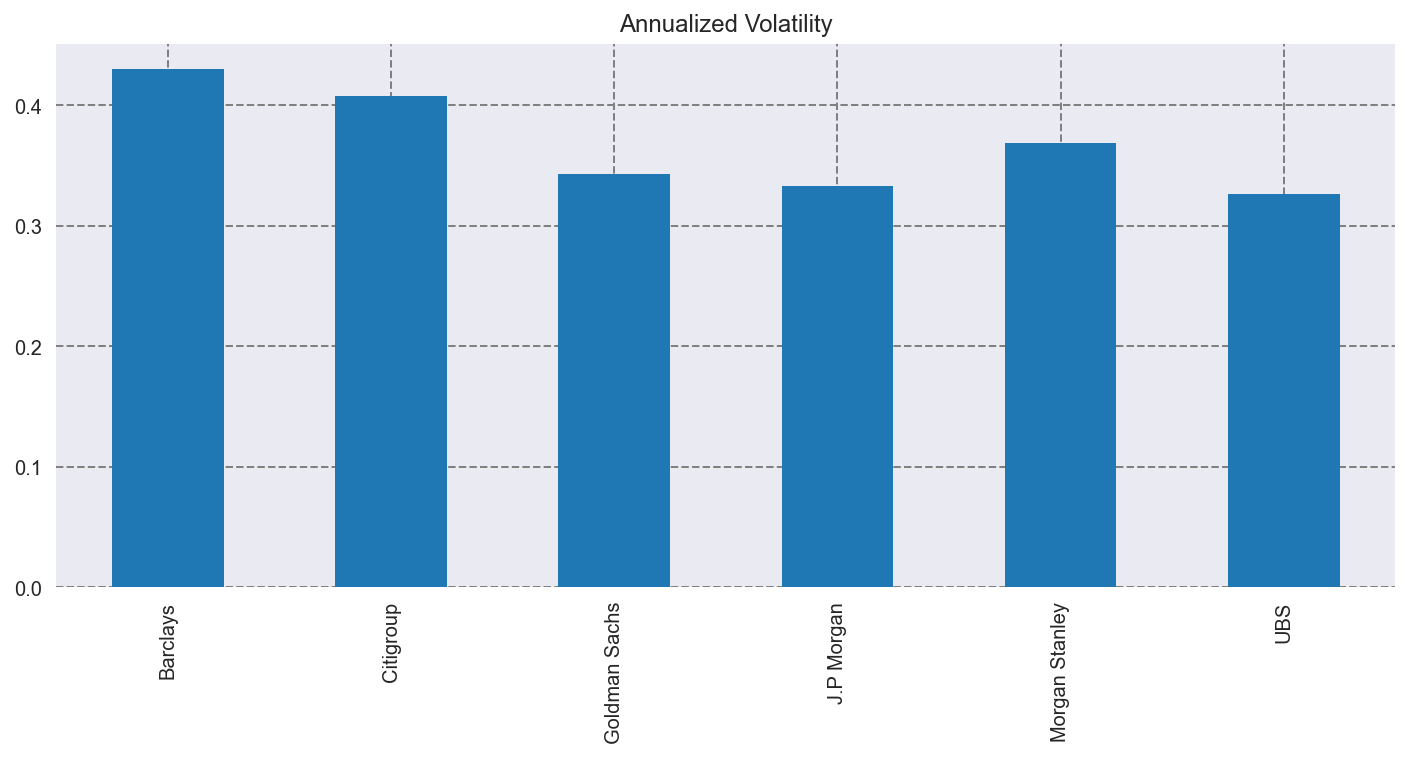

In [10]:
returns_df= np.log(stocks_adj_close_price/stocks_adj_close_price.shift(1))
daily_volatility = returns_df.std() 

volatility = daily_volatility*np.sqrt(252)
volatility.plot(kind = 'bar', colormap = 'tab20', figsize = (12,5))
plt.title('Annualized Volatility')
plt.grid(linestyle = '--', c = 'grey');

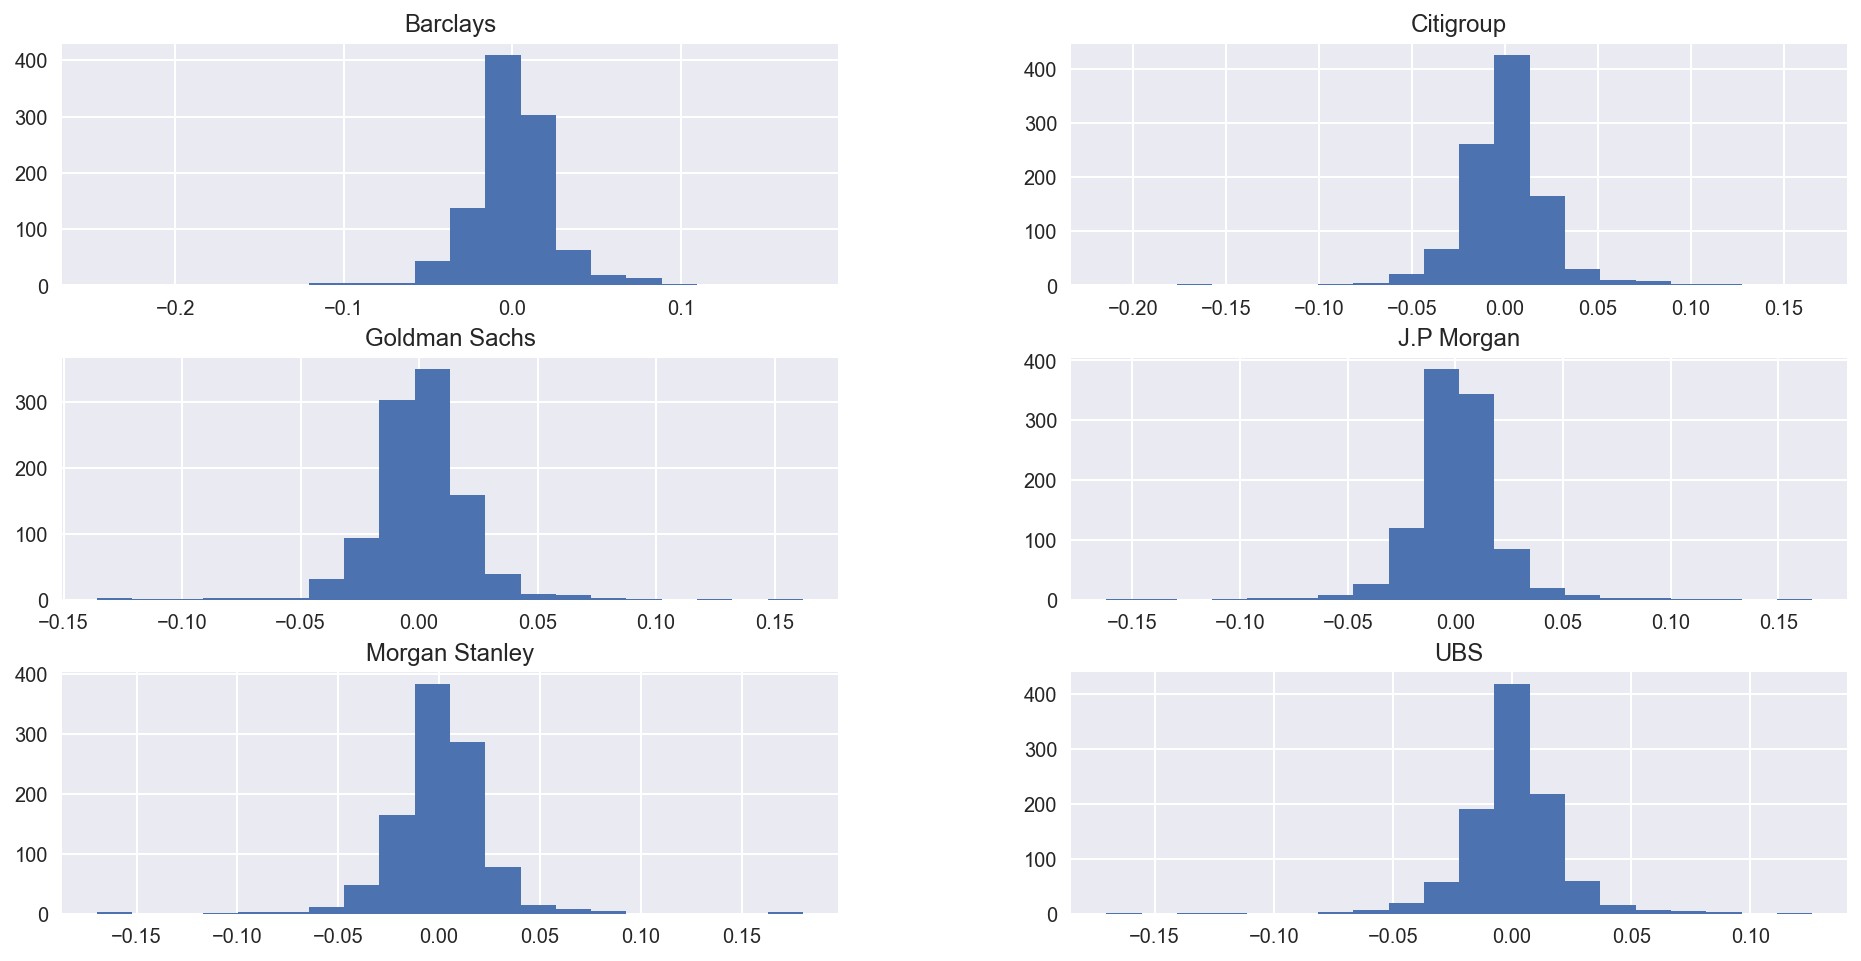

In [11]:
returns_df.hist(bins  = 20, figsize = (16,8));

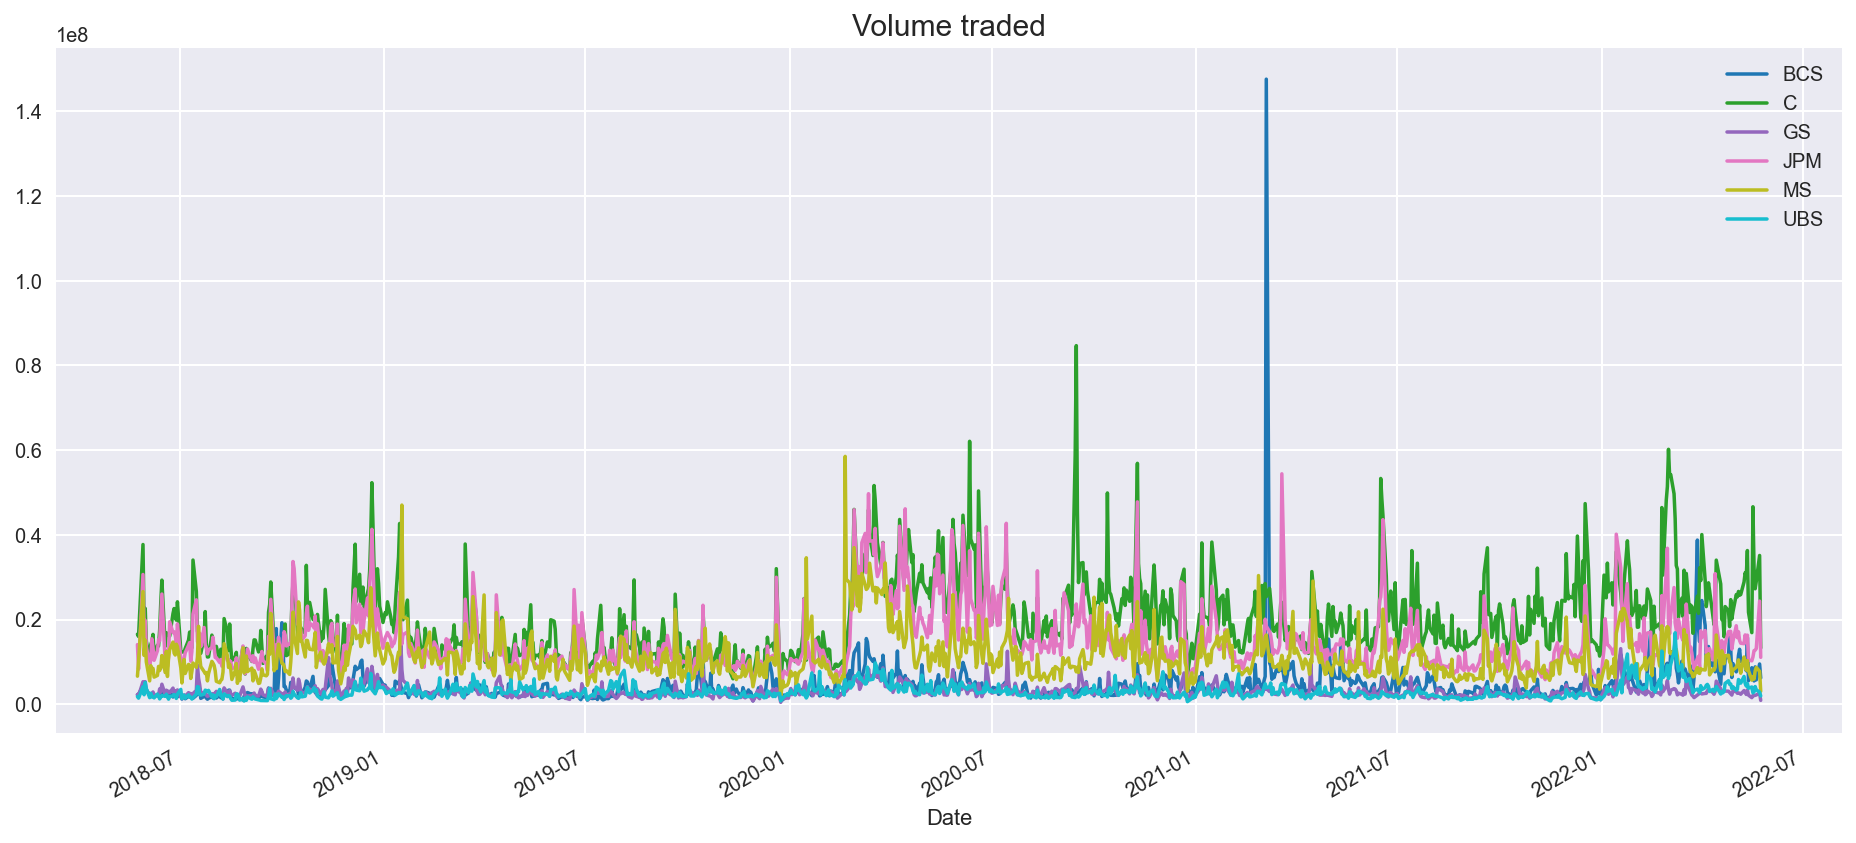

In [12]:
stock_volumes = stock_data['Volume'].copy()
stock_volumes.plot(figsize = (16,7), colormap = 'tab10')
plt.title('Volume traded', fontdict={'fontsize':15});

#### Market Capitalisation

In [13]:
stocks_close_price = stock_data['Close'].copy()
tickers =stocks_close_price.columns

def num_shares_outstanding(*tikers):
    data = {}
    for x in tickers:
        yahoo_financials = YahooFinancials(x)
        value = yahoo_financials.get_num_shares_outstanding()
        data[x] = int(value)
        num_shares_outstanding = pd.DataFrame(data, index = ['Shares Outstanding']).T
    return num_shares_outstanding 


shares_outstanding = num_shares_outstanding(tickers)
shares_outstanding

Shares Outstanding
BCS          4190499938
C            1941920034
GS            343447029
JPM          2937100094
MS           1749280045
UBS          3349140033

In [14]:
stocks_close_price = stock_data['Close'].copy()
df = pd.DataFrame(index = stocks_close_price.columns)

market_cap = {}
for i in range(len(stocks_close_price.columns)):
    value = stocks_close_price.iloc[-1, i] * shares_outstanding.iloc[i,0]
    market_cap[shares_outstanding.index[i]] = int(value)
    
    
market_cap = pd.DataFrame(market_cap, index = ['Market Capitalisation']).T
Market_capitalisation = shares_outstanding.join(market_cap).sort_values(by ='Market Capitalisation', ascending=True)
Market_capitalisation

Shares Outstanding  Market Capitalisation
BCS          4190499938            34864958205
UBS          3349140033            62227021557
C            1941920034           101368227256
GS            343447029           106638583592
MS           1749280045           141569234575
JPM          2937100094           367548703970

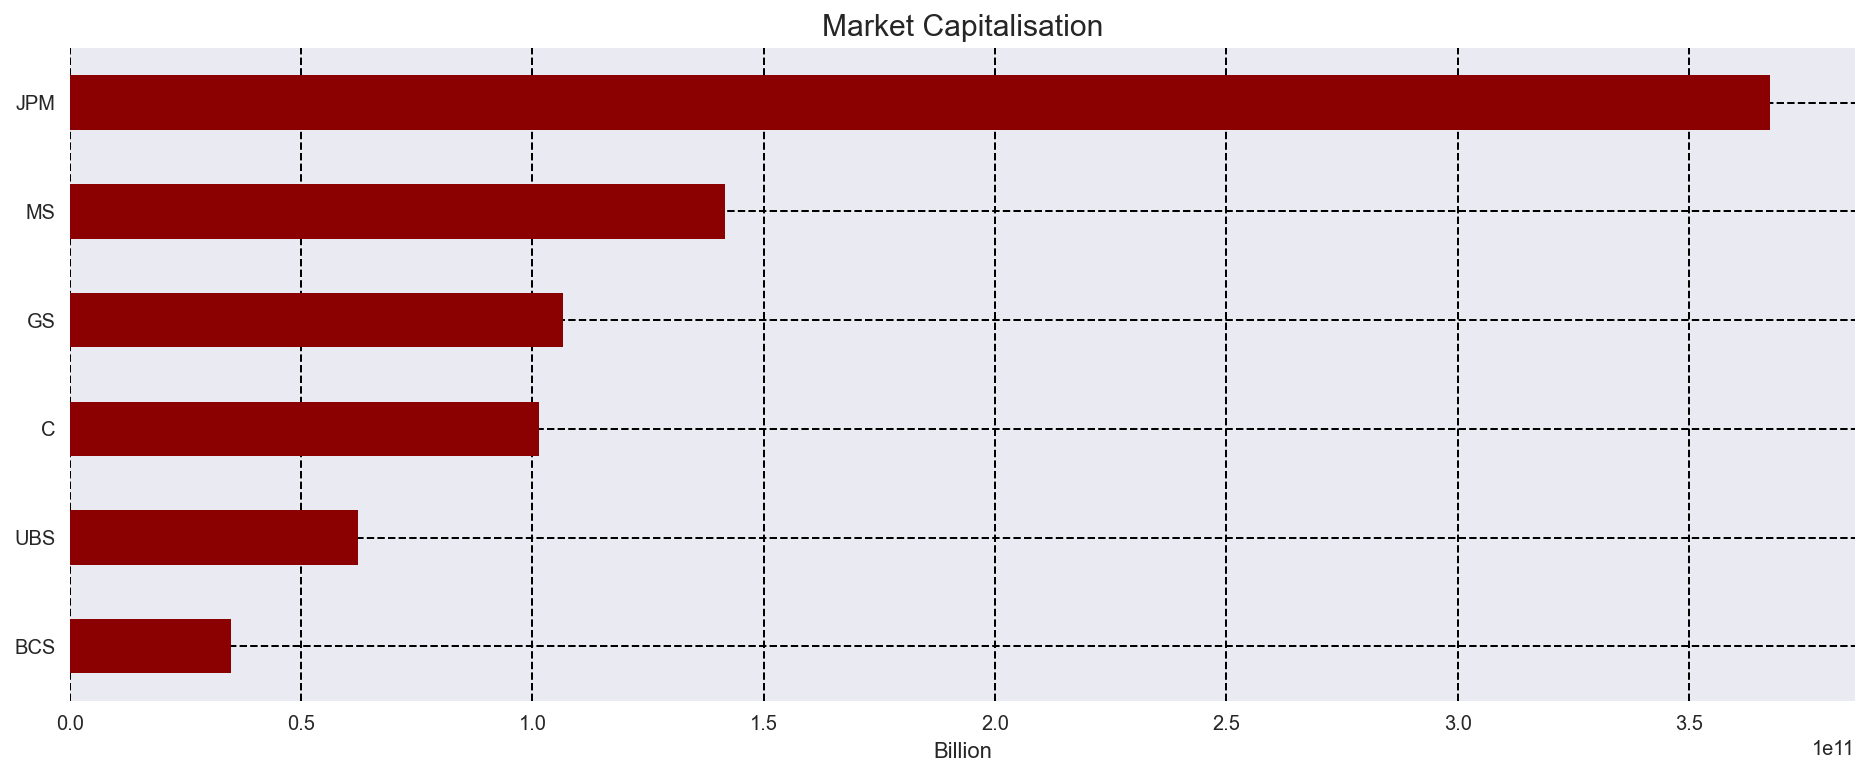

In [15]:
Market_capitalisation['Market Capitalisation'].plot(kind = 'barh', figsize = (16,6), color = 'Darkred')
plt.title('Market Capitalisation', fontdict={'fontsize': 15})
plt.xlabel('Billion')
plt.grid(linestyle = '--', c = 'k');

Let's see the relationship that exists between stocks and their respective price movements.

In [16]:
stocks_adj_close_price.corr()

Barclays  Citigroup  Goldman Sachs  J.P Morgan  \
Barclays        1.000000   0.816339       0.789758    0.826775   
Citigroup       0.816339   1.000000       0.535491    0.686079   
Goldman Sachs   0.789758   0.535491       1.000000    0.952508   
J.P Morgan      0.826775   0.686079       0.952508    1.000000   
Morgan Stanley  0.735161   0.435078       0.983599    0.925274   
UBS             0.786135   0.421543       0.904272    0.824680   

                Morgan Stanley       UBS  
Barclays              0.735161  0.786135  
Citigroup             0.435078  0.421543  
Goldman Sachs         0.983599  0.904272  
J.P Morgan            0.925274  0.824680  
Morgan Stanley        1.000000  0.924046  
UBS                   0.924046  1.000000

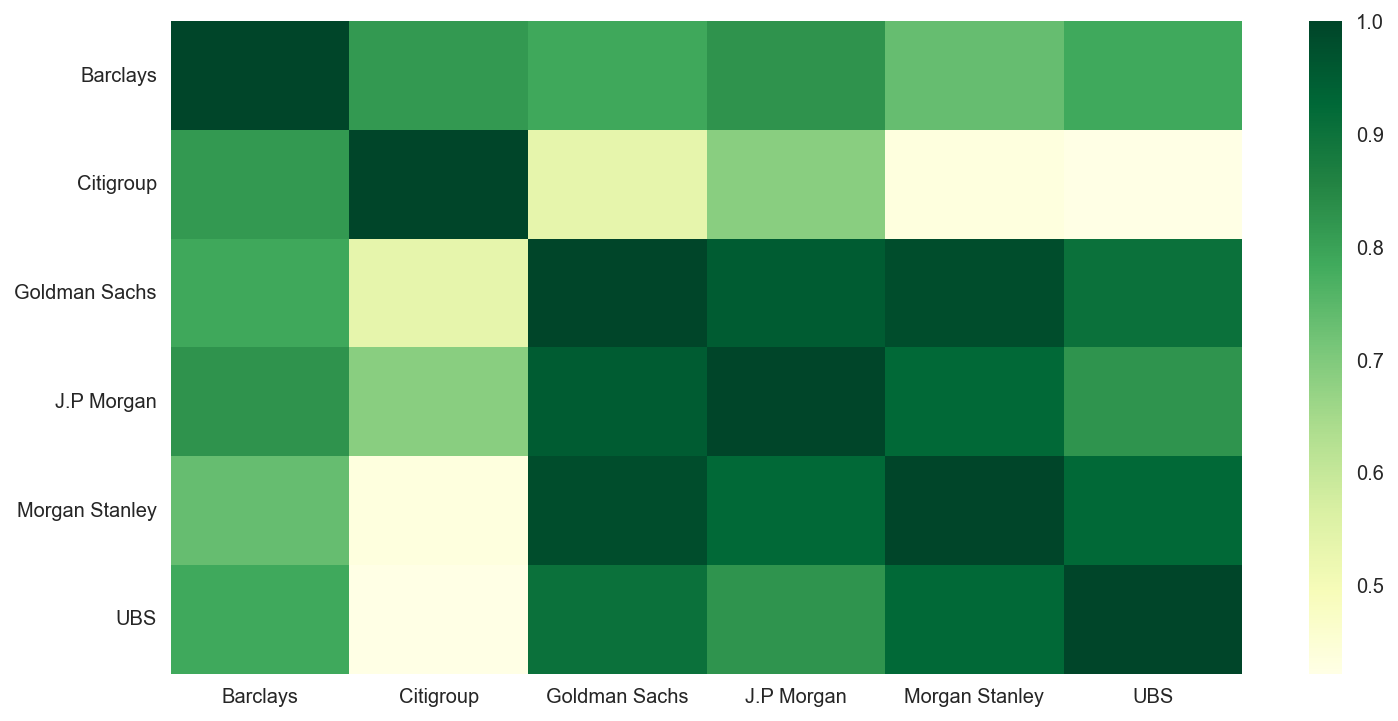

In [17]:
plt.figure(figsize = (12,6))
sns.heatmap(stocks_adj_close_price.corr(),cmap='YlGn');

# Part II


In [18]:
#J.P Morgan's Stock attributes
jpm_stock_data = stock_data.unstack()[:,'JPM'].to_frame().unstack().T.droplevel(0).copy()

In [19]:
jpm_stock_data.head()

Adj Close       Close  Dividends        High         Low  \
Date                                                                   
2018-05-24  98.950867  111.230003        0.0  112.150002  110.120003   
2018-05-25  98.443794  110.660004        0.0  111.080002  110.199997   
2018-05-29  94.235939  105.930000        0.0  109.199997  104.959999   
2018-05-30  96.388802  108.349998        0.0  108.599998  106.650002   
2018-05-31  95.196724  107.010002        0.0  108.190002  106.419998   

                  Open  Stock Splits      Volume  
Date                                              
2018-05-24  112.139999           0.0  14084800.0  
2018-05-25  110.459999           0.0   8283500.0  
2018-05-29  109.180000           0.0  30643800.0  
2018-05-30  107.639999           0.0  17490800.0  
2018-05-31  107.949997           0.0  19808200.0

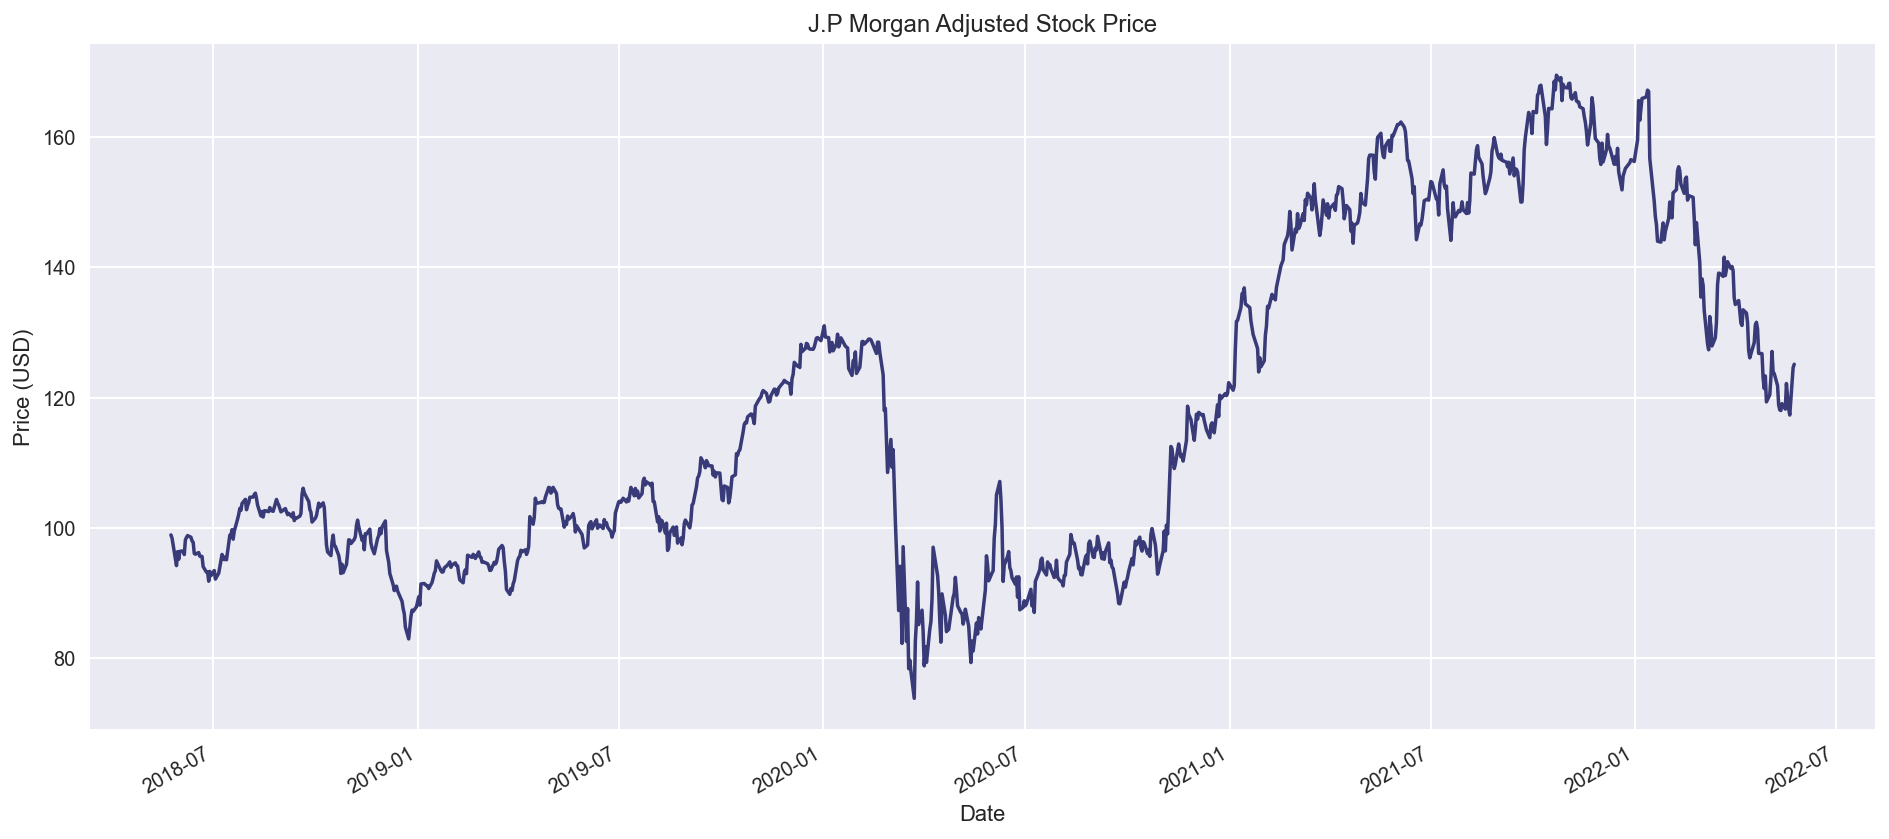

In [20]:
jpm_stock_data['Adj Close'].plot(figsize = (16,7), title = 'J.P Morgan Adjusted Stock Price', colormap = 'tab20b')
plt.ylabel('Price (USD)');

In [21]:
#summary statistics
jpm_stock_data.describe().round(2)

Adj Close    Close  Dividends     High      Low     Open  Stock Splits  \
count    1008.00  1008.00    1008.00  1008.00  1008.00  1008.00        1008.0   
mean      117.99   124.31       0.01   125.61   123.07   124.34           0.0   
std        25.30    23.32       0.11    23.37    23.27    23.33           0.0   
min        73.88    79.03       0.00    83.75    76.91    81.56           0.0   
25%        96.39   105.20       0.00   106.06   104.34   105.12           0.0   
50%       107.19   116.48       0.00   117.36   115.38   116.59           0.0   
75%       144.05   146.70       0.00   148.80   144.37   145.69           0.0   
max       169.50   171.78       1.00   172.96   170.54   172.71           0.0   

            Volume  
count      1008.00  
mean   14874454.13  
std     7020937.69  
min     3324300.00  
25%    10241525.00  
50%    13018900.00  
75%    17056950.00  
max    54418800.00

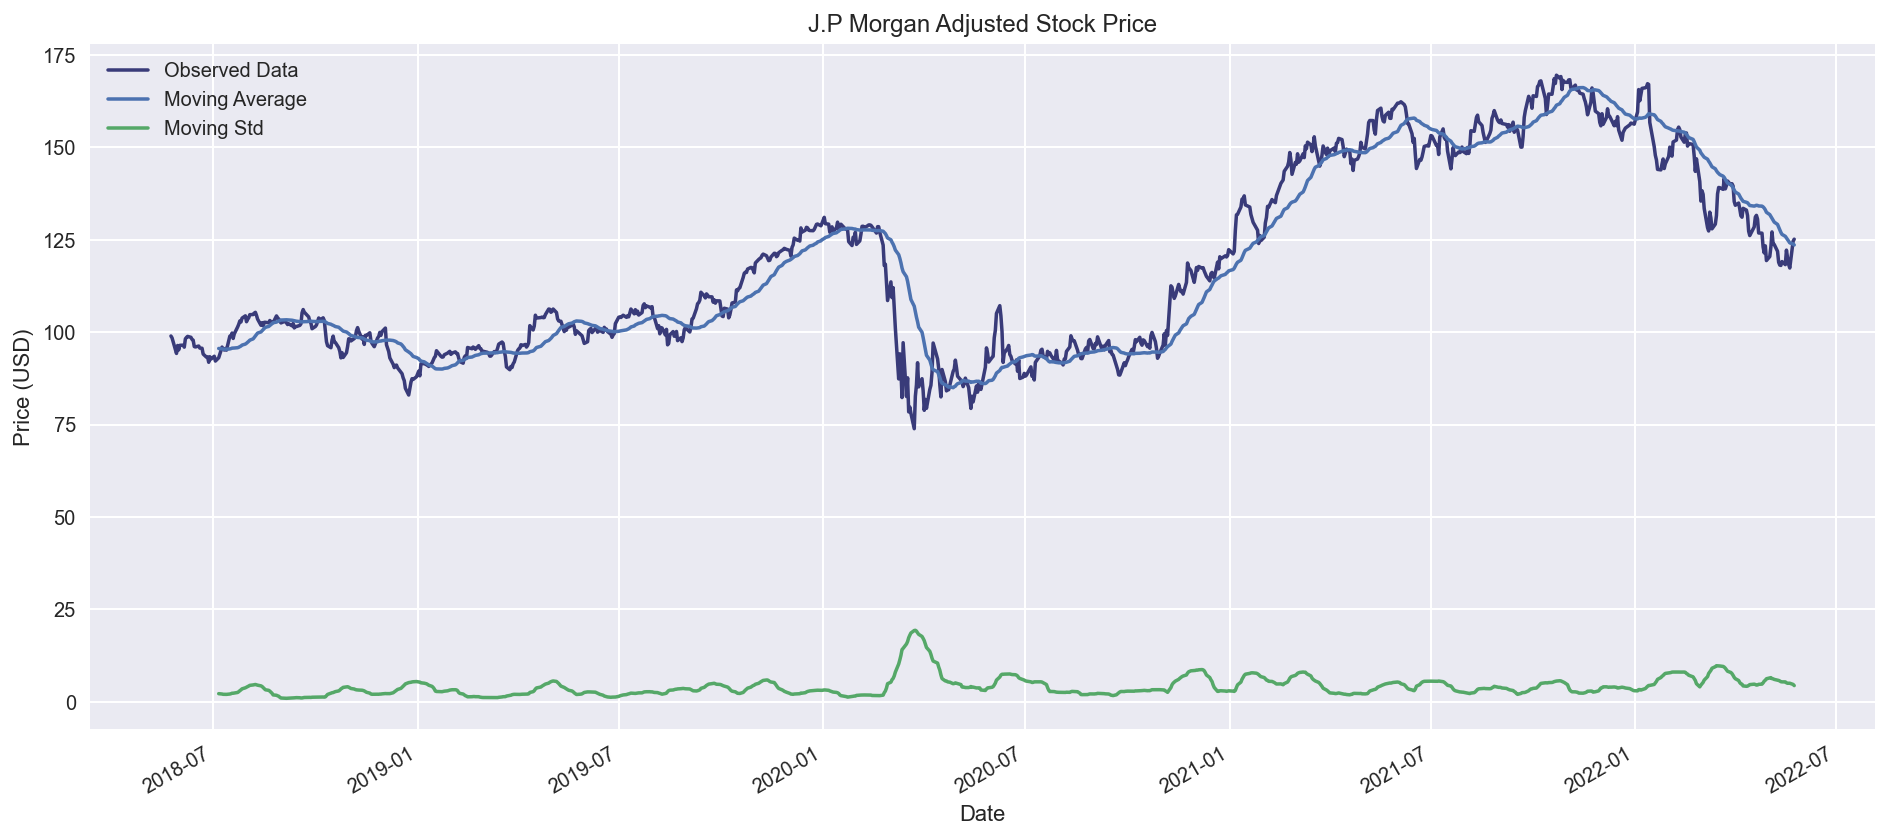

In [22]:
jpm_stock_data['ma_30'] = jpm_stock_data['Adj Close'].rolling(30).mean()
jpm_stock_data['msd_30'] = jpm_stock_data['Adj Close'].rolling(30).std()

jpm_stock_data['Adj Close'].plot(figsize = (16,7),label = 'Observed Data', legend = True, title = 'J.P Morgan Adjusted Stock Price', colormap = 'tab20b')
jpm_stock_data['ma_30'].plot(label = 'Moving Average', legend = True)
jpm_stock_data['msd_30'].plot(label = 'Moving Std', legend = True)
plt.ylabel('Price (USD)');

In [23]:
jpm_stock_data['Log returns'] = np.log(jpm_stock_data['Adj Close'])- np.log(jpm_stock_data['Adj Close'].shift(1))
jpm_stock_data['Simple returns'] = jpm_stock_data['Adj Close'].pct_change()

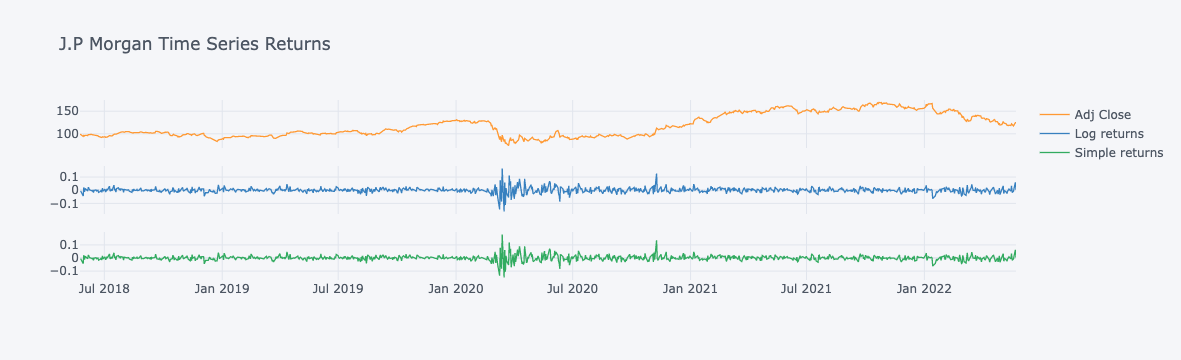

In [24]:
jpm_stock_data[['Adj Close', 'Log returns', 'Simple returns']].iplot(
    subplots=True, shape=(3,1),
    shared_xaxes=True,
    title='J.P Morgan Time Series Returns')

Skew: 0.415
Mean: 0.0005
Median: -0.0
Standard deviation of returns
0.021


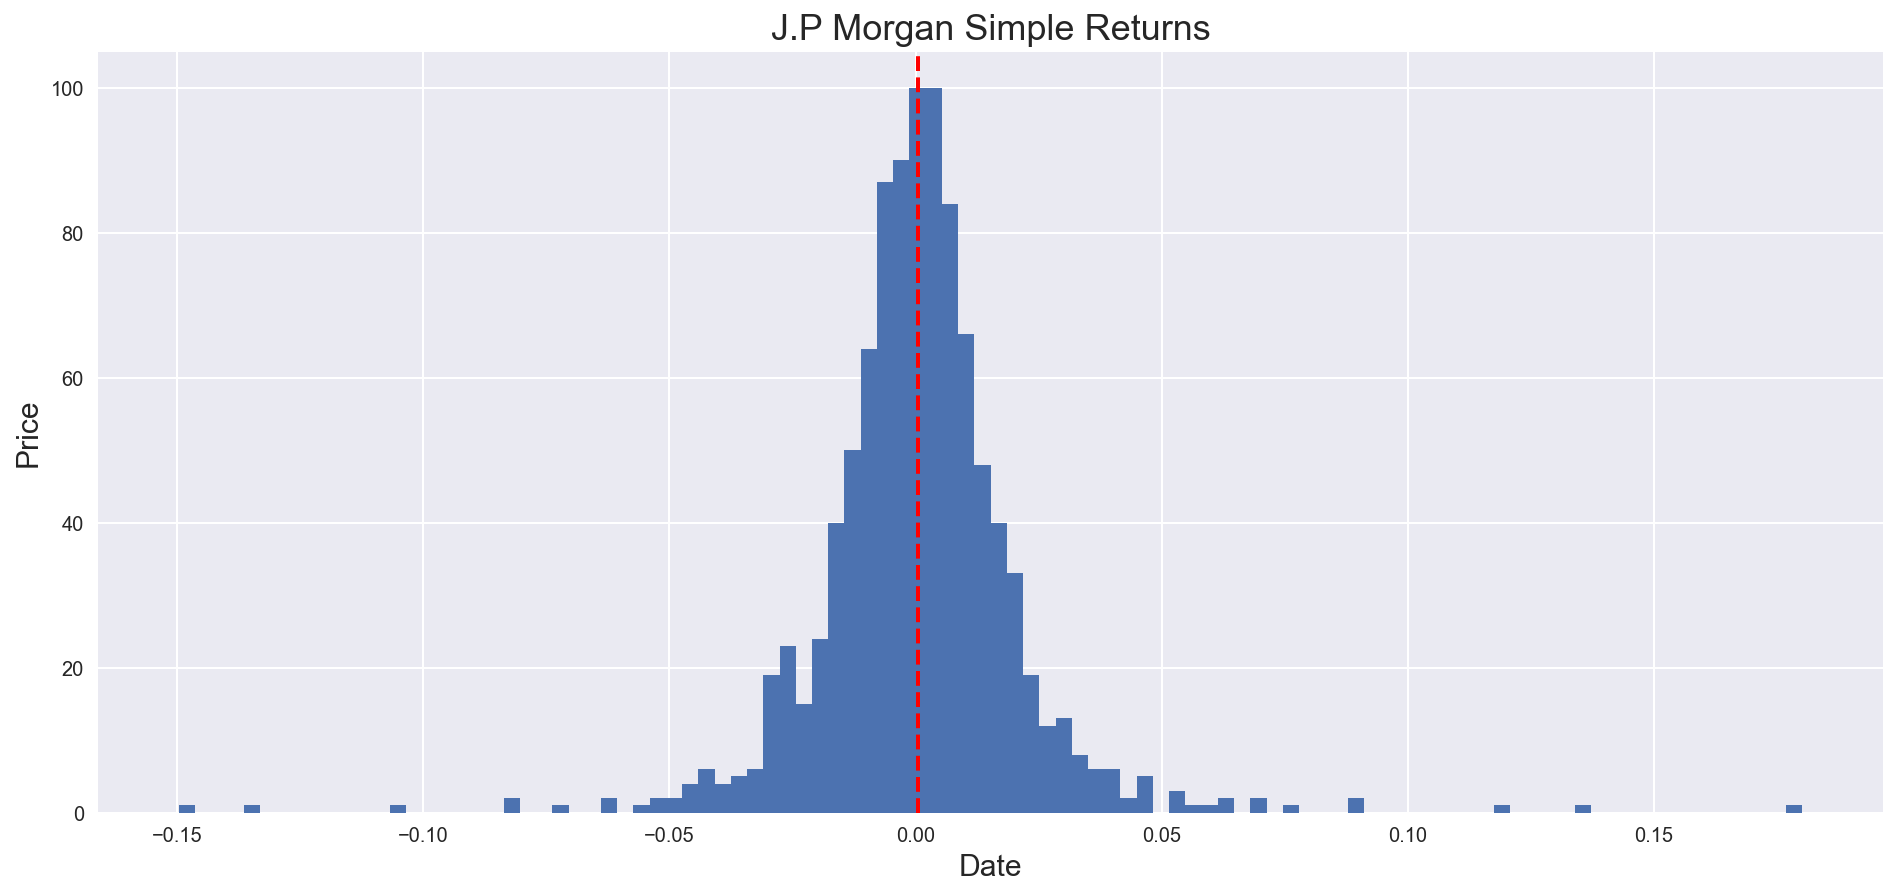

In [25]:
# Histogram of Daily Returns
print('Skew:', round(stats.skew(jpm_stock_data['Simple returns'].dropna()),3))
print('Mean:', round(np.mean(jpm_stock_data['Simple returns']), 4))
print('Median:', round(np.median(jpm_stock_data['Simple returns'].dropna()),3))
print('Standard deviation of returns')
print(round(jpm_stock_data['Simple returns'].std(),3))

plt.figure(figsize = (16,7))
plt.hist(jpm_stock_data['Simple returns'], bins=100, label='Daily Returns data')
plt.axvline(jpm_stock_data['Simple returns'].mean(), color='r', linestyle='dashed', linewidth=2) # Shows the average line
plt.title('J.P Morgan Simple Returns',fontsize=18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price', fontsize = 15 )
plt.show()

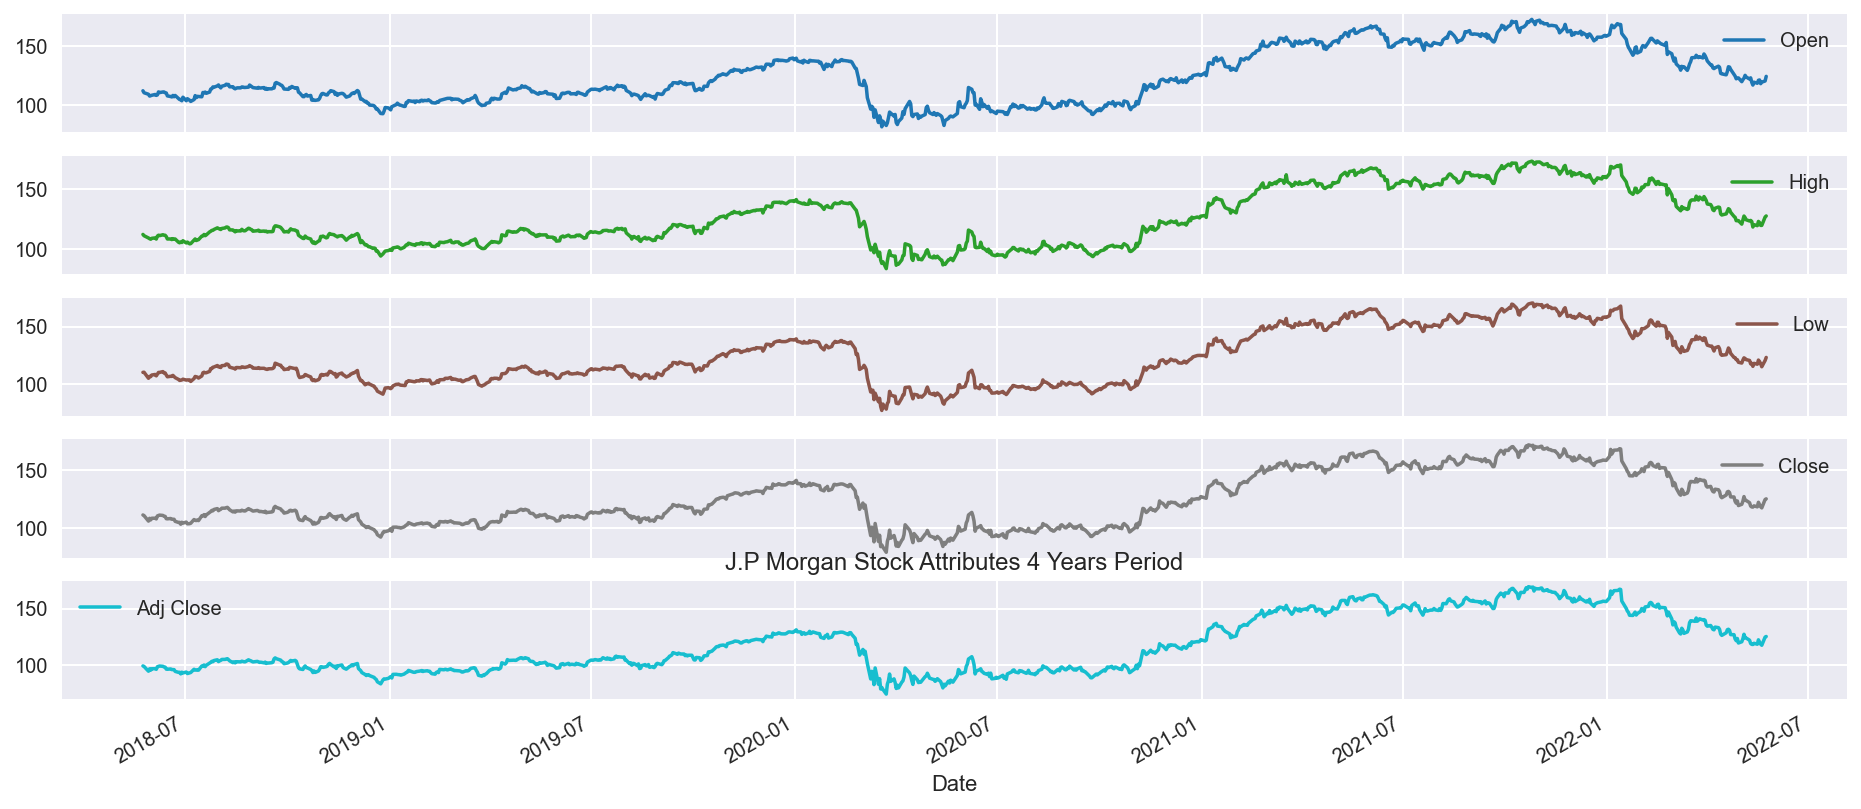

In [26]:
jpm_stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close']].plot(figsize = (16,7), subplots = True, colormap = 'tab10');
plt.title('J.P Morgan Stock Attributes 4 Years Period')
plt.show()

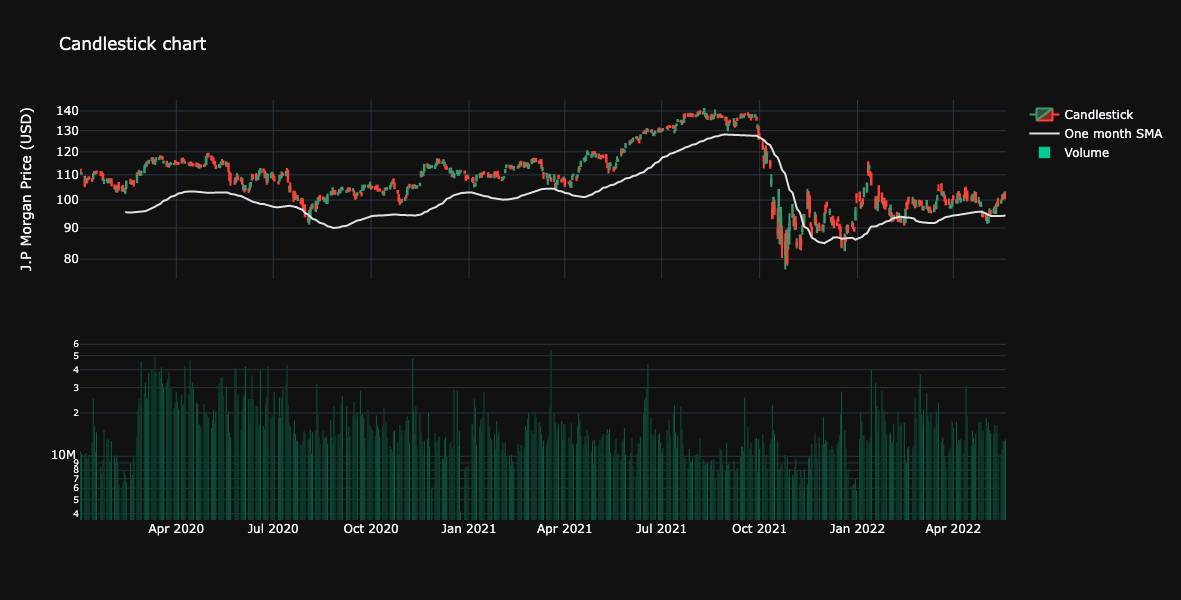

In [27]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Candlestick(x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
                                      open = jpm_stock_data['Open'],
                                       high=jpm_stock_data['High'],
                                       low=jpm_stock_data['Low'],
                                       close=jpm_stock_data['Close'],
                                       name = 'Candlestick'),row=1, col=1
             )
fig.add_trace(
    go.Scatter(
        x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index, 
        y = jpm_stock_data['ma_30'],
        line = dict(color = '#e0e0e0'), name = 'One month SMA'
    ))



fig.add_trace(
    go.Bar(x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
           y=jpm_stock_data.loc['2020-01-01':'2022-05-20','Volume'], name = 'Volume'),
    secondary_y=False, row=2, col=1)


fig.update_layout(
    title_text = 'Candlestick chart',
    xaxis_rangeslider_visible = False, template = 'plotly_dark', 
                  yaxis_title = 'J.P Morgan Price (USD)', width=1000, height=600,)

fig.update_yaxes(type = 'log')
fig.show()

## Time Series Decomposition 

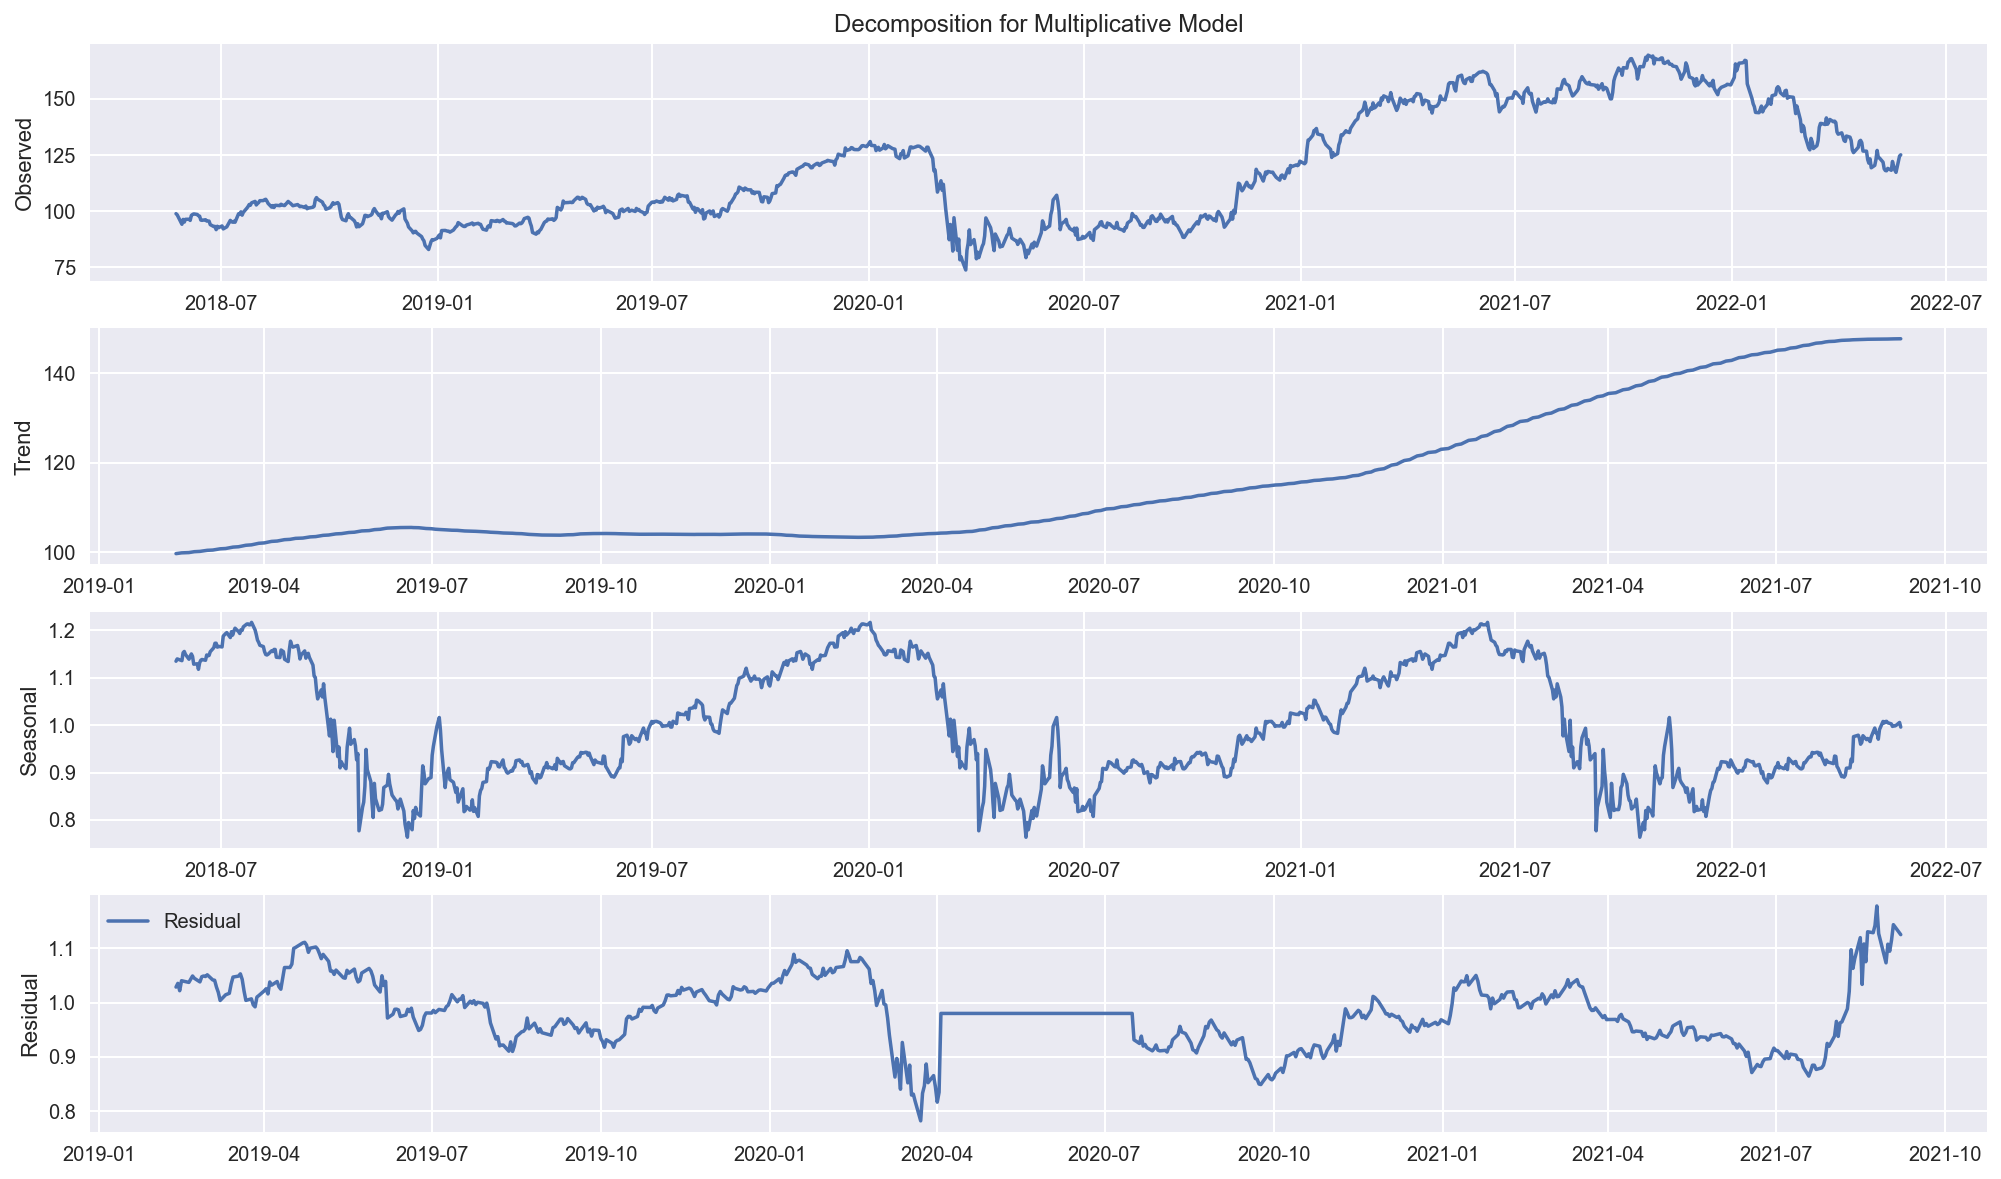

In [28]:
jpm_close_price = jpm_stock_data['Adj Close'].to_frame().copy()
decomposed_jpm_close_price = seasonal_decompose(jpm_close_price, period=360, model = 'multiplicative')

fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_jpm_close_price.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition for Multiplicative Model')

ax[1].plot(decomposed_jpm_close_price.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_jpm_close_price.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_jpm_close_price.resid, label = 'Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

Given the decomposition of the data set we can observe the presence of a polynomial trendand additive seasonality. In the residual plot the data seems to be random, no evidence of patterns.

#### Testing for stationarity
The basic assumption in modeling is that each observation should be independent of other realizations. If the independence assumption does not hold, the result of the model cannot be reliable anymore. Stationary is a way to model the dependent structure that we have in time-dependent data. For instance, the current stock price is somewhat related to the previous prices of the stock.

In time series, it is common to have non-stationary data, and taking differences is a way to make non-stationary data stationary. Another way of detecting the non-stationarity is to apply the Autocorrelation Function. Autocorrelation implies serial dependence. Precisely, it occurs when a time series is highly correlated with its lagged version. It is shown by the ACF plot. The height of the bar in the ACF plot, the more dependence a series has and if decaying slowly this is an indicator of non-stationarity.

In [29]:
# Augmented Dickey-Fuller  unit root test
def ADF_test(data):
    """
    Perform Augmented Dickey-Fuller Test
    The number of considered lags is automatically selected based 
    on the Akaike Information Criterion (AIC)
    Ho = Null Hypothesis -> The data are not stationary
    H1 = Alternate Hypotesis -> The data are stationary
    """
    
    result  = adfuller(data, autolag = 'AIC')
    print(f'ADF Statistic:{result[0]}')
    print (f'P-value: {result[1]}')
    print('Critical Values:')
    for x, y in result[4].items():
        print(f'{x} : {y}')
    if result[1] > 0.05:
        print('We accept the Null Hypotesis. Data are not stationary!')
    else:
        print('We accept the Alternate Hypotesis. Data are Stationary!')

ADF_test(jpm_close_price)


ADF Statistic:-1.411002400514701
P-value: 0.576990211190001
Critical Values:
1% : -3.43694584277544
5% : -2.8644520725172873
10% : -2.5683205291305176
We accept the Null Hypotesis. Data are not stationary!


In [30]:
#find the optimal number of differencing
from pmdarima.arima.utils import ndiffs
ndiffs(jpm_close_price, test = 'adf')


1

In [31]:
jpm_close_price['First_differencing'] = jpm_close_price - jpm_close_price.shift(1)
#With a transformation applied to our series, we can test for stationarity again using the ADF test.
#verify if data are stationary
ADF_test(jpm_close_price['First_differencing'].dropna())

ADF Statistic:-9.1945136058098
P-value: 2.0800712608532896e-15
Critical Values:
1% : -3.43694584277544
5% : -2.8644520725172873
10% : -2.5683205291305176
We accept the Alternate Hypotesis. Data are Stationary!


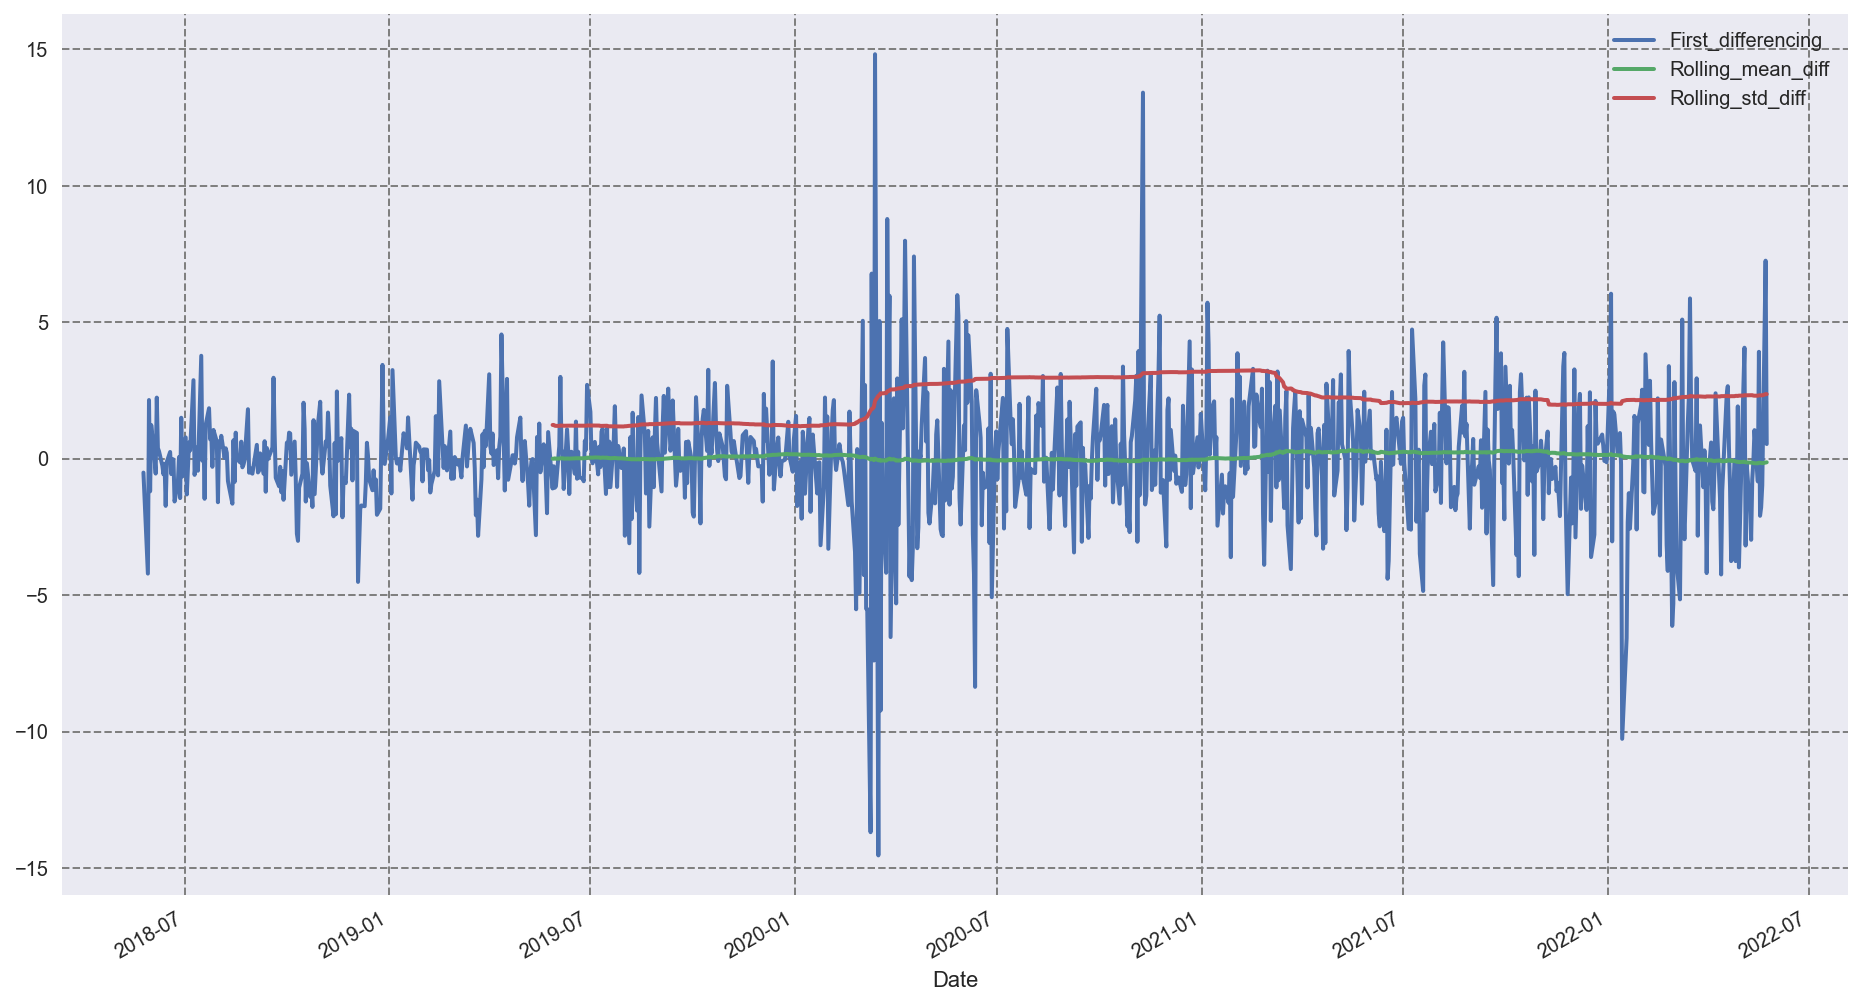

In [32]:
jpm_close_price['Rolling_mean_diff'] = jpm_close_price['First_differencing'].rolling( window=252).mean()
jpm_close_price['Rolling_std_diff'] = jpm_close_price['First_differencing'].rolling( window=252).std()
jpm_close_price[['First_differencing', 'Rolling_mean_diff', 'Rolling_std_diff']].plot(figsize = (16,9), lw =2.0);
plt.grid(linestyle = '--', c = 'grey')

### Autocorrelation and Partial Auocorrelation functions

After taking the first difference, it is quite obvious that the series fluctuates around its mean and it is referred to as weakly stationary.

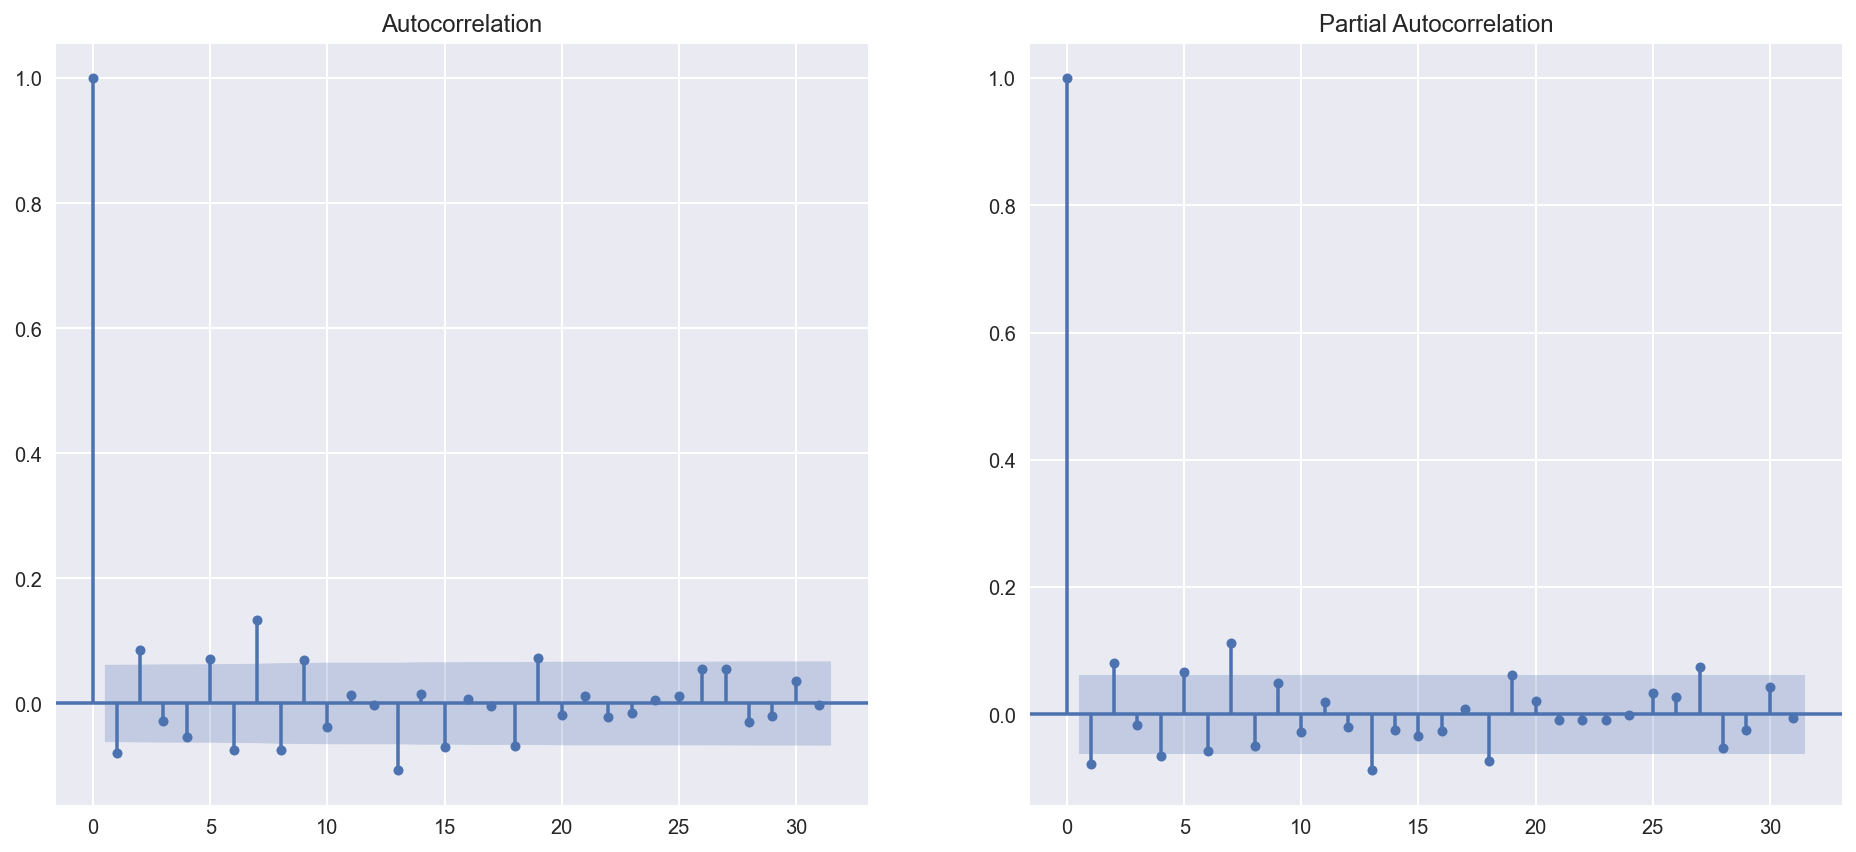

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
plot_acf(jpm_close_price['First_differencing'].dropna(), alpha = 0.05, ax = ax[0])
plot_pacf(jpm_close_price['First_differencing'].dropna(), alpha = 0.05, ax = ax[1]);


## Exponencial Smoothing
Smoothing is a statistical method we can use to create an approximation function to remove irregularities in data and attempt to capture significant patterns.
The smoothing technique is a family of time-series forecasting algorithms, which utilizes the weighted averages of a previous observation to predict or forecast a new value. The main idea of this technique is to overweight recent values in a time series.

I will perform univariate analysis on the adjusted close price of the stock and forecasting using Simple Exponential Smoothing, Holt's Exponential Smoothing, and Holt - Winter Exponential Smoothing.

In [34]:
#to perform exponential smoothing I am going to take weekly data
jpm_week_data = jpm_stock_data['Adj Close'].copy().resample('W').mean().to_frame()

train_data_es= jpm_week_data.iloc[:int(jpm_week_data.shape[0]*0.90)]
test_data_es= jpm_week_data.iloc[int(jpm_week_data.shape[0]*0.90):]
train_data_es.rename(columns = {'Adj Close': 'Train data'}, inplace = True)
test_data_es.rename(columns = {'Adj Close': 'Test data'}, inplace = True)
print('Total:', jpm_week_data.shape[0])
print('Train data size:', train_data_es.shape[0])
print('Test data size:', test_data_es.shape[0])

Total: 210
Train data size: 189
Test data size: 21


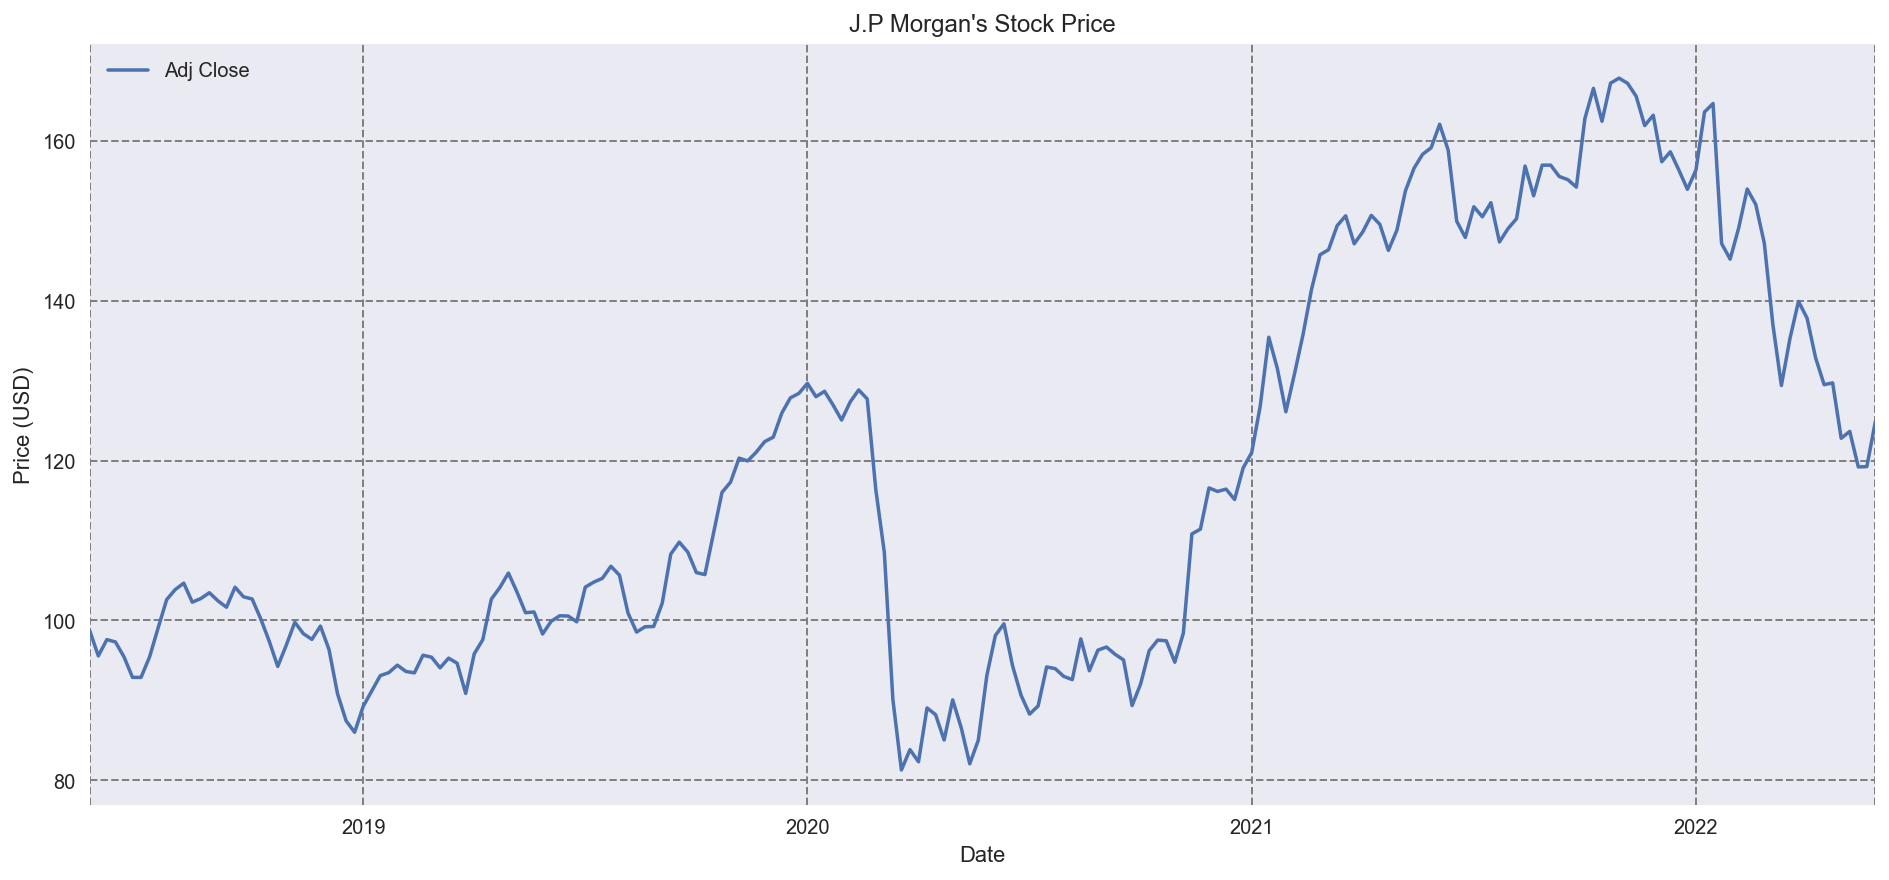

In [35]:
jpm_week_data.plot(title="J.P Morgan's Stock Price", figsize = (16,7));
plt.ylabel('Price (USD)')
plt.legend(loc = 'upper left')
plt.grid(linestyle = '--', c = 'grey');

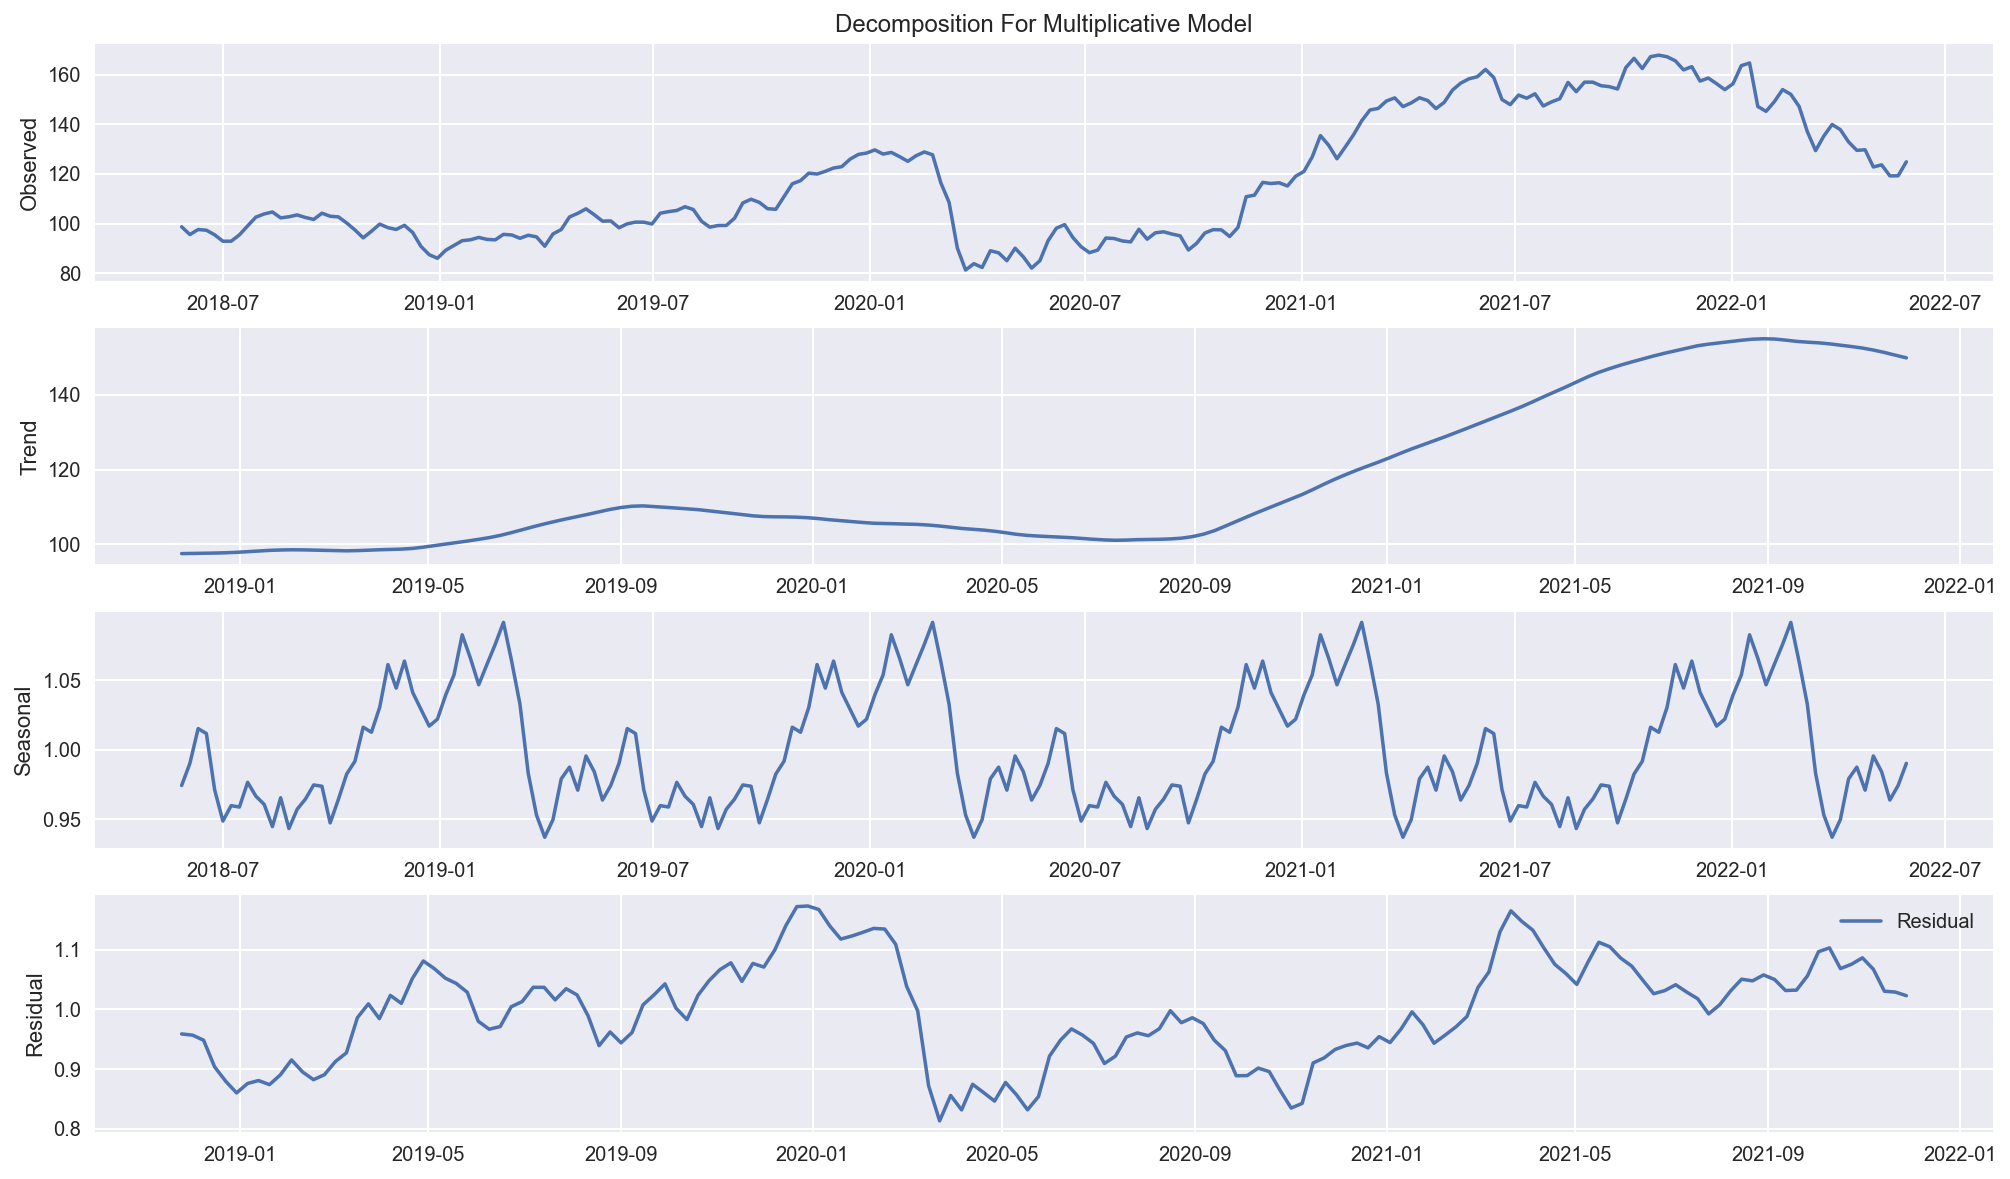

In [36]:
decomposed_weekly_data = sm.tsa.seasonal_decompose(jpm_week_data, model = 'multiplicative')

fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_weekly_data.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition For Multiplicative Model')

ax[1].plot(decomposed_weekly_data.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_weekly_data.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_weekly_data.resid, label = 'Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

I will create a function that has all the required evaluation metrics, which will give us the results in one go. This function helps us understand how far off our forecasts are against the actuals.

In [37]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
        #Evaluation metric results
        MSE= metrics.mean_squared_error(y_true, y_pred)
        MAE = metrics.mean_absolute_error(y_true, y_pred)
        RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
        MAPE = mean_absolute_percentage_error(y_true, y_pred)
        R2 = metrics.r2_score(y_true, y_pred)

In [38]:
resu = []
temp_df = pd.DataFrame()
for i in [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    
    fit_v = SimpleExpSmoothing(np.asarray(train_data_es)).fit(i)
    fcst_pred_v= fit_v.forecast(len(test_data_es))
    
    timeseries_evaluation_metrics_func(test_data_es,fcst_pred_v)
    rmse = np.sqrt(mean_squared_error(test_data_es, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

smoothing parameter       RMSE
7                  0.7  22.080117
6                  0.6  22.109814
8                  0.8  22.138486

From the previous search, the least RMSE was achieved with smoothing_level equal to 1.0. But we need to be aware since choosing smoothing parameter with least RMSE can lead us to overfitting, this is why I will apply  	$\alpha$ = 0.2, since it is used more frequently.

In [39]:
#when alpha is high the dacay is faster and we give less weight to past data and viceversa
ses_1 = SimpleExpSmoothing(train_data_es).fit(smoothing_level=0.2)
ses_1_forecast = ses_1.forecast(len(test_data_es))

#Here we allow statsmodels to automatically find an optimized value aplha
ses_3 = SimpleExpSmoothing(train_data_es).fit()
alpha = ses_3.model.params['smoothing_level']
ses_3_forecast = ses_3.forecast(len(test_data_es))

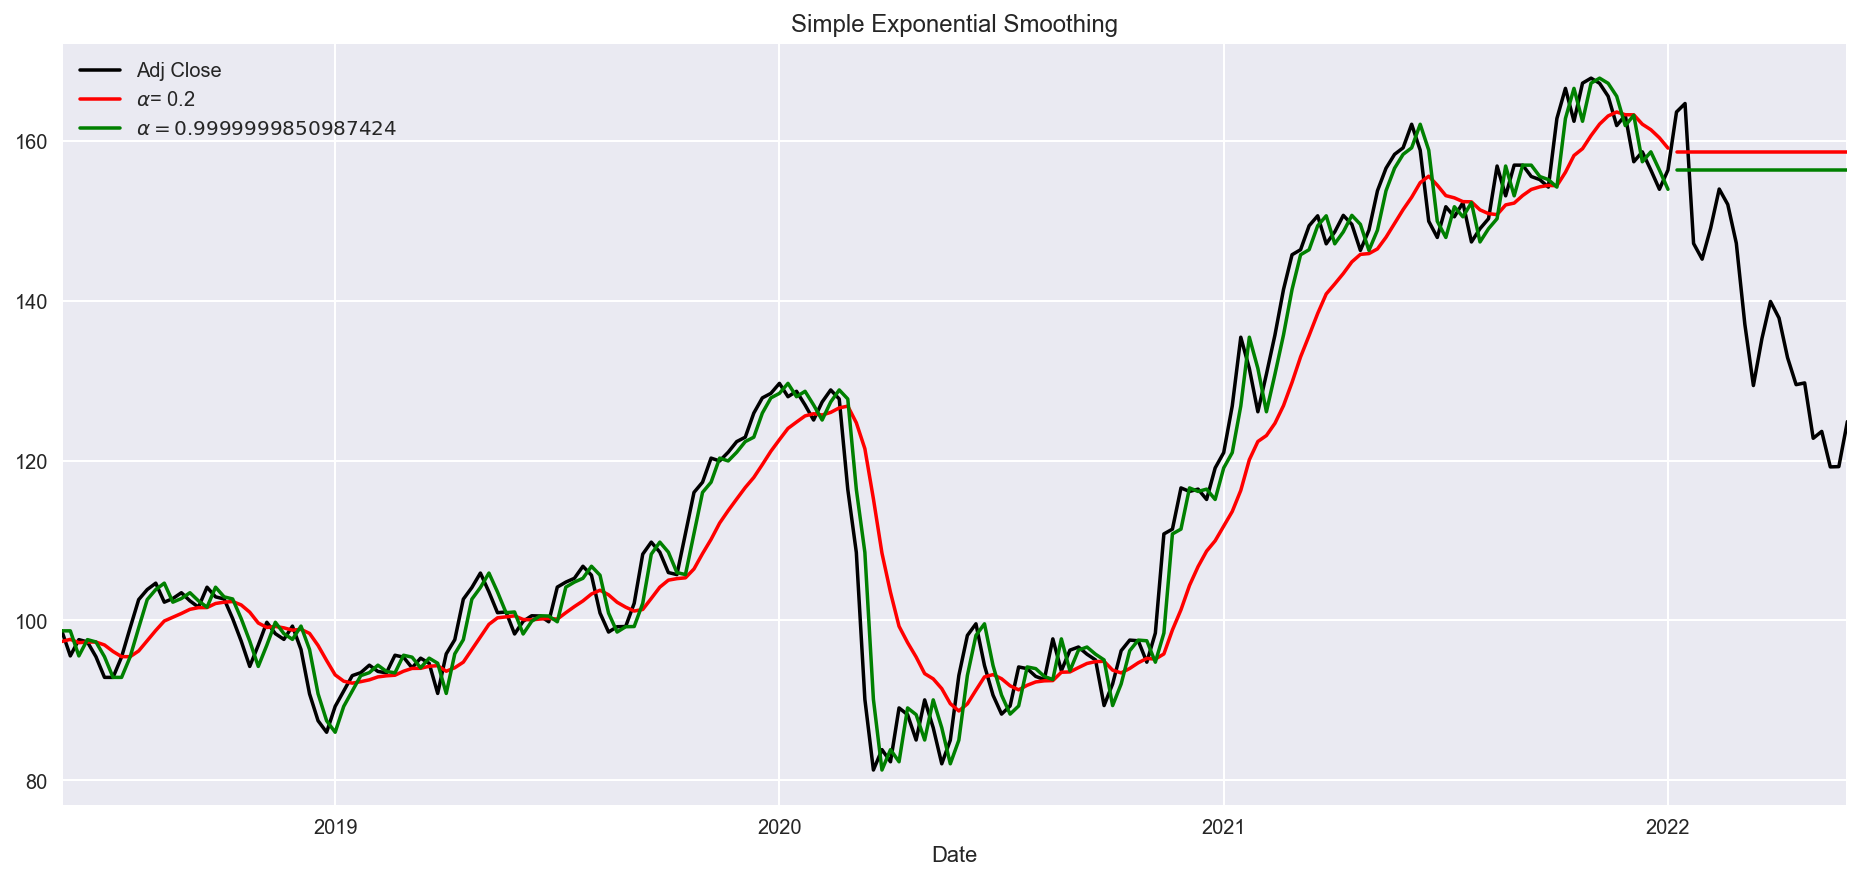

In [40]:
jpm_week_data.plot(color = 'k',
                    title = 'Simple Exponential Smoothing',
                    legend = True,
                    figsize = (16,7))
ses_1_forecast.plot(label = r'$\alpha$= 0.2', color ='r',legend = True)
ses_1.fittedvalues.plot(color ='r')

ses_3_forecast.plot(label = r'$\alpha ={} $'.format(alpha), 
                    color = 'green',legend = True)
ses_3.fittedvalues.plot(color = 'green')
plt.show()

We can see that the simple exponential smoothing is not performing well on the stock market data, since they have trends and seasonality. Our basic model will not be able to capture these details.

### Double Exponential Smoothing / Holt's Esponential Smoothing

Holt's exponential smoothing is an extension of Simple Exponencial Smoothing, and integrate trend term. The time series must have following features - Level, Trend, Noise (unpredictable), No Seasonality. In the model we can two updating equations:
* The Level updating equation with $\alpha$- smoothing parameter
* The Trend updating equation with $\beta$ - smoothing slope

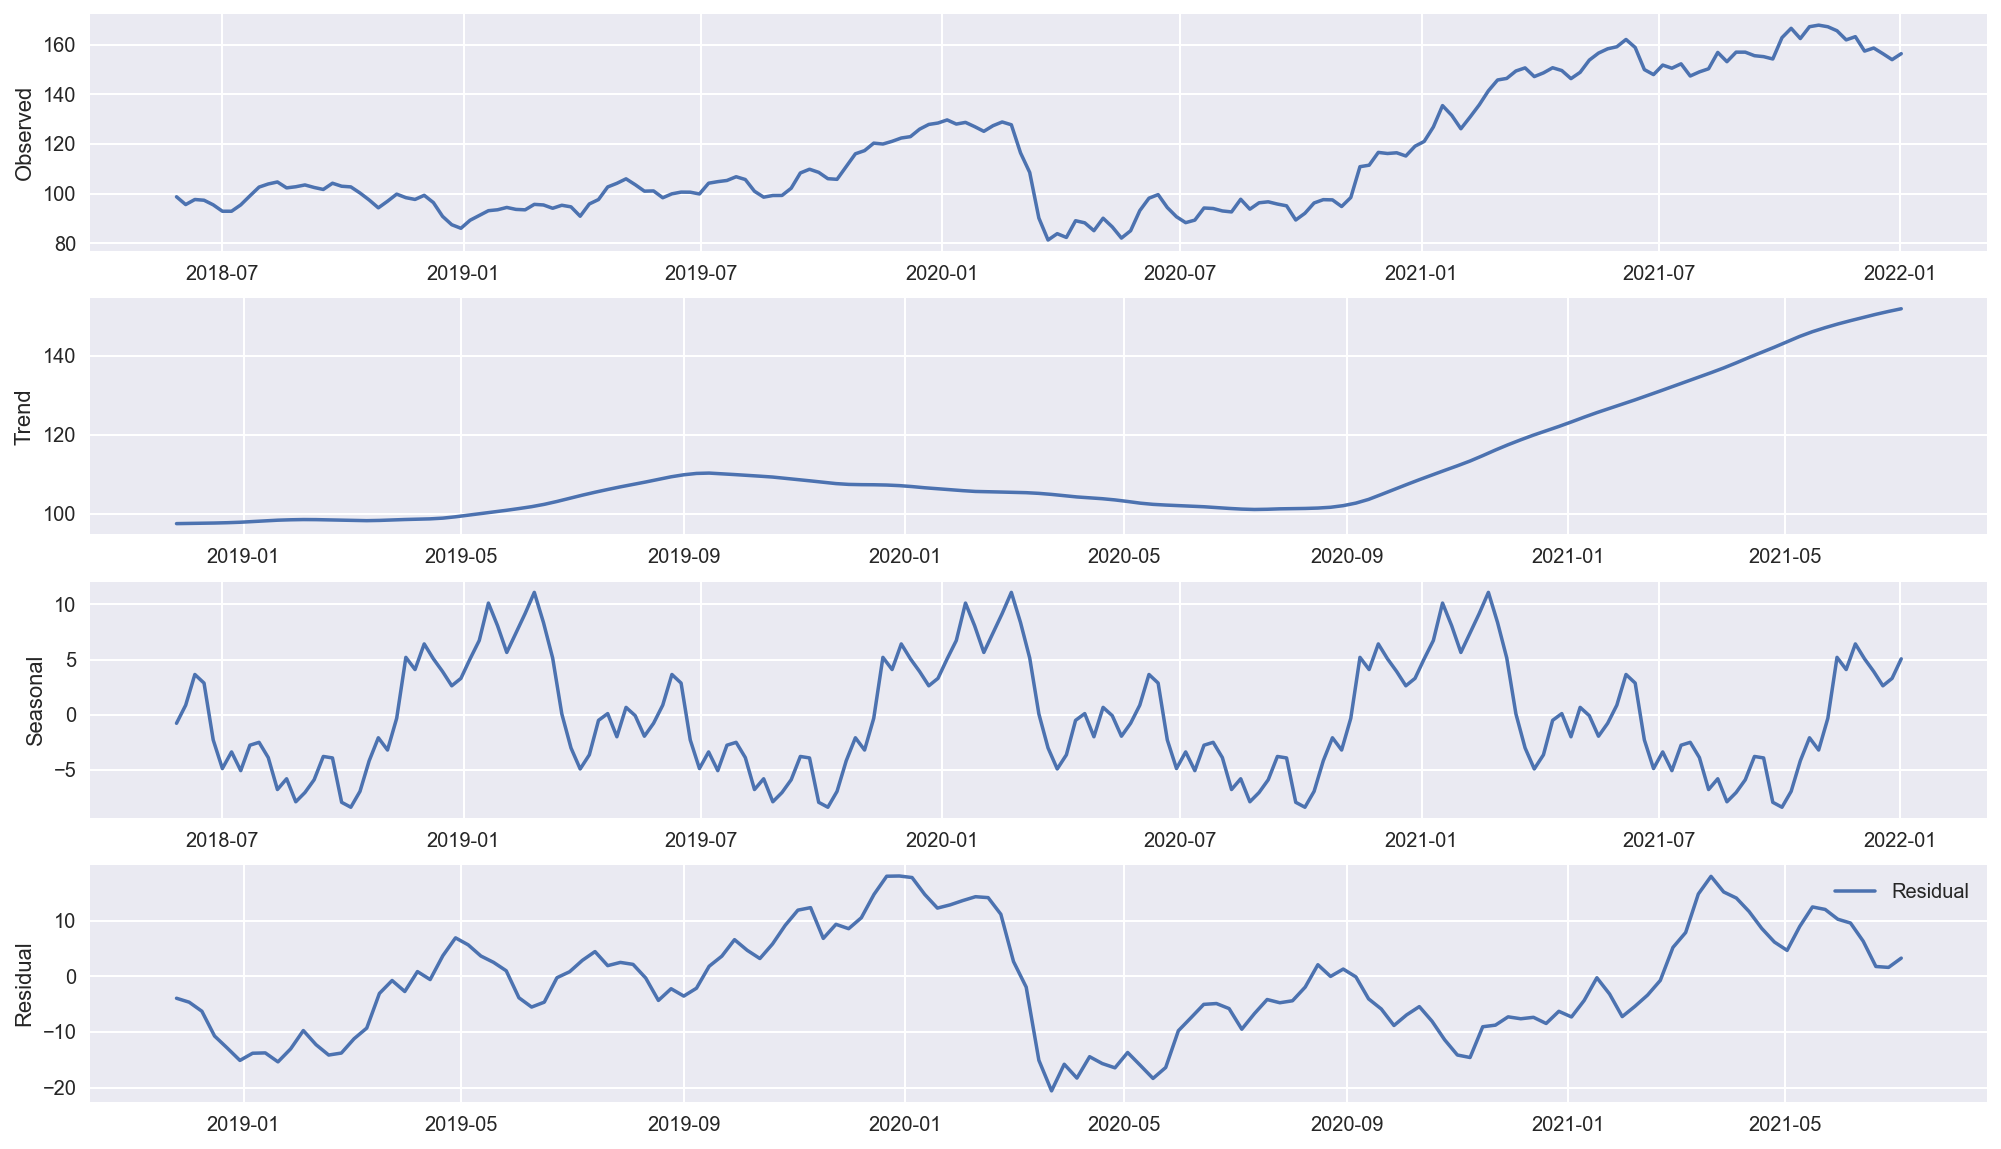

In [41]:
#decompose train data and plot it
decomposed_jpm_price = seasonal_decompose(train_data_es, period = 52)
fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_jpm_price.observed)
ax[0].set_ylabel('Observed')
ax[1].plot(decomposed_jpm_price.trend)
ax[1].set_ylabel('Trend')
ax[2].plot(decomposed_jpm_price.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')
ax[3].plot(decomposed_jpm_price.resid, label = 'Residual')
ax[3].set_ylabel('Residual')
plt.legend()
plt.show()

We could observe that the data has a polynomial trend and additive seasonality. 

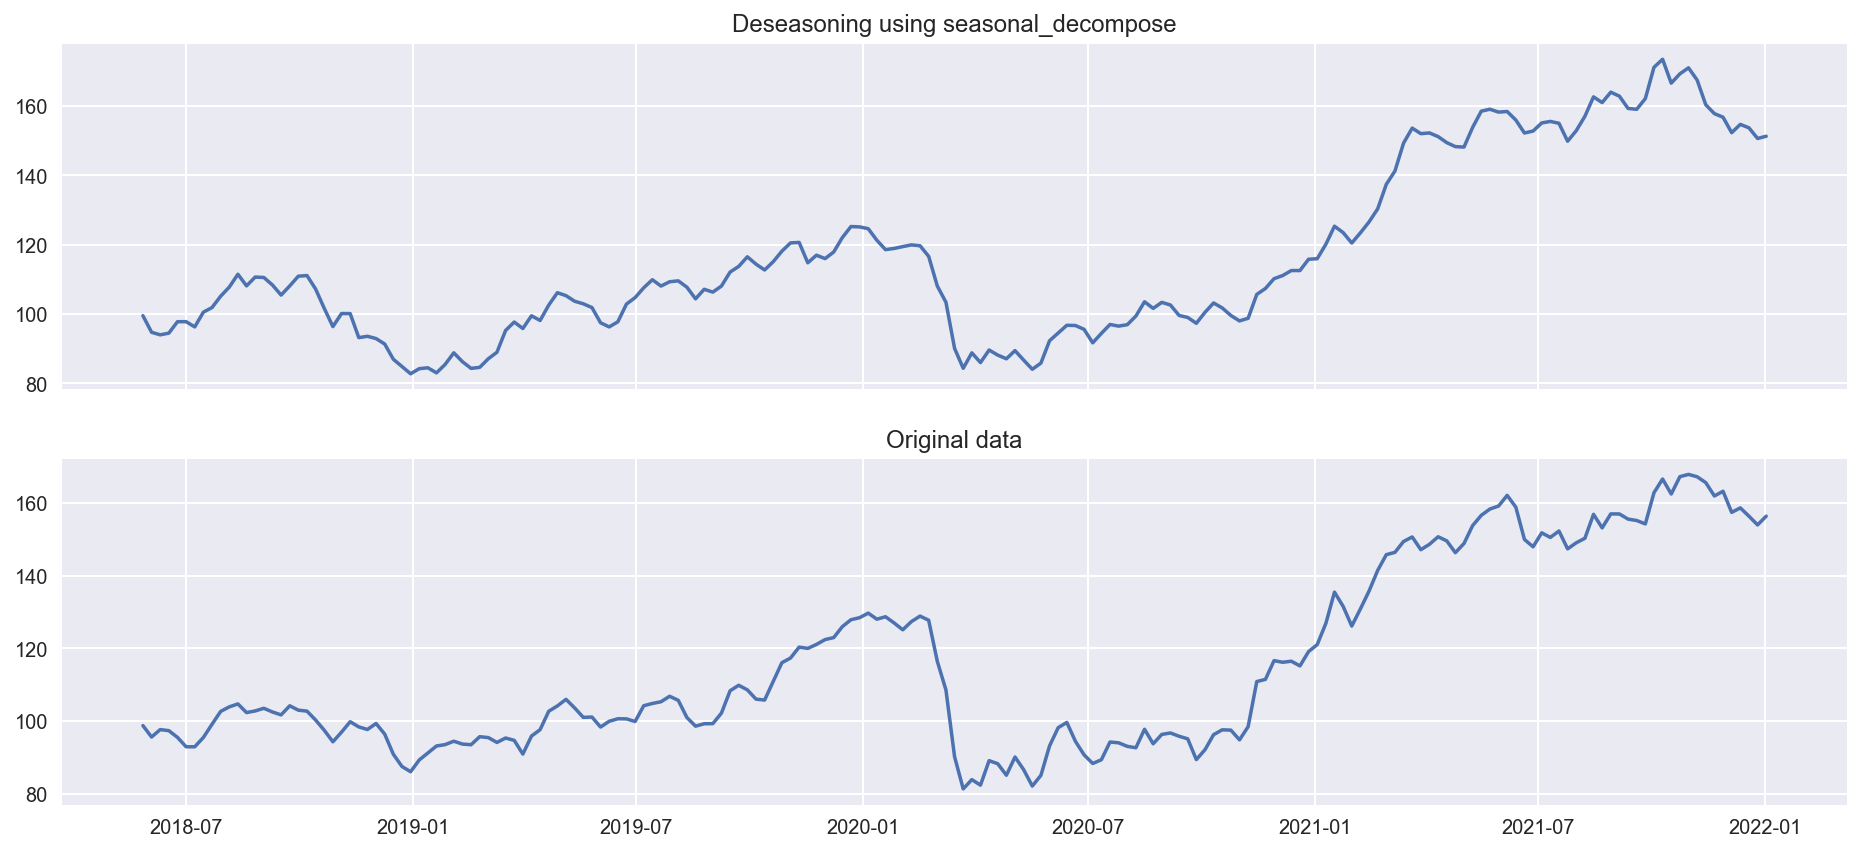

In [42]:
deseason_data = train_data_es['Train data'] - decomposed_jpm_price.seasonal
deseason_data.dropna(inplace = True)
#plot for comparison
fig, ax = plt.subplots(2,1, sharex = True, figsize = (16,7))
ax[0].plot(deseason_data)
ax[0].set_title('Deseasoning using seasonal_decompose')
ax[1].plot(train_data_es)
ax[1].set_title('Original data');

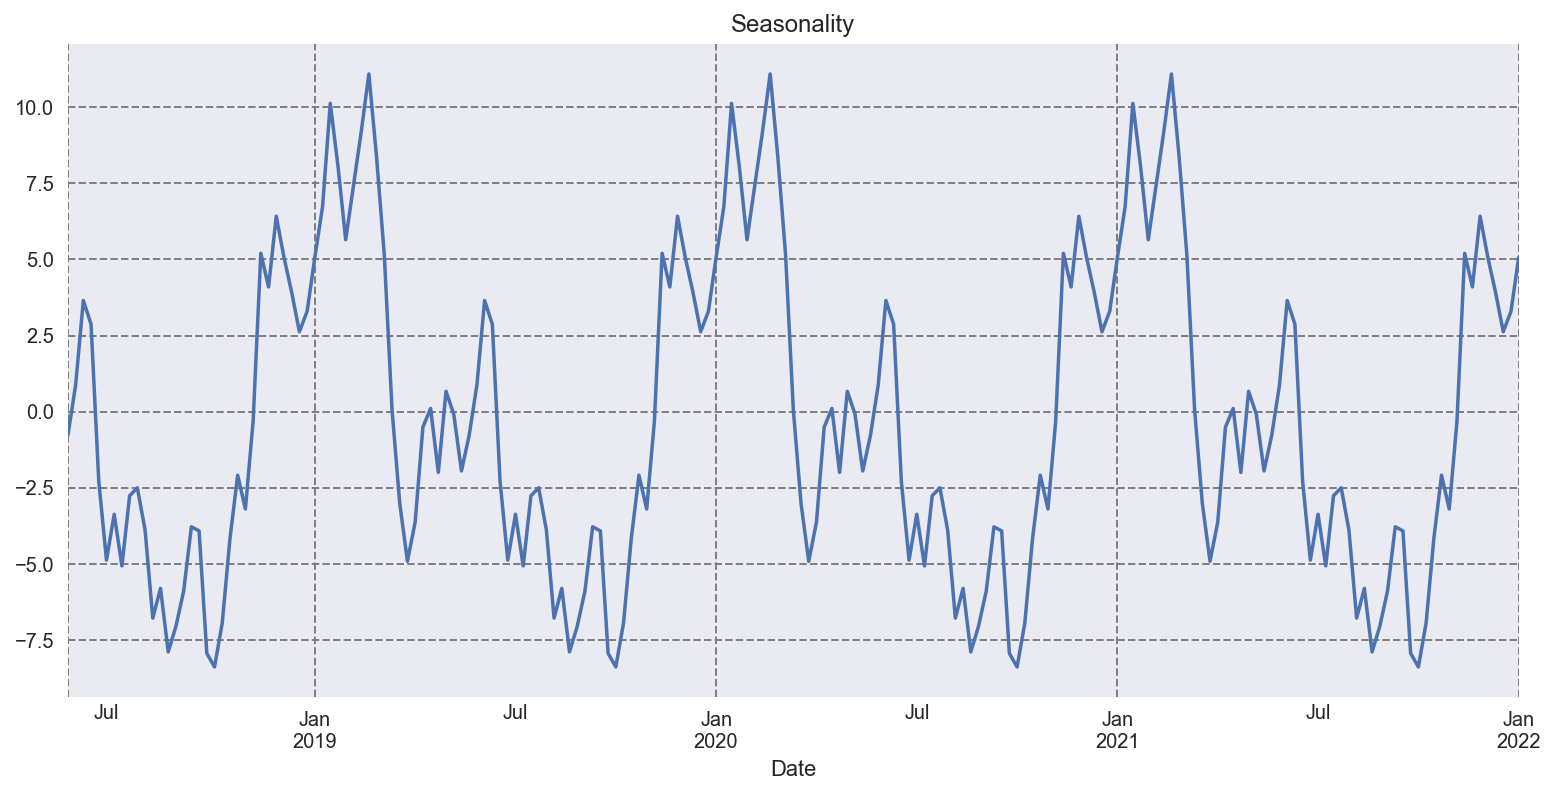

In [43]:
seasonality =decomposed_jpm_price.seasonal
seasonality.plot(title = 'Seasonality', figsize = (13,6))
plt.grid(linestyle = '--', c = 'grey');

In the seasonality graph, we can see the seasonality structure for every year, which is cyclic and repeatedly provides the same values.

In [44]:
model_1 = ExponentialSmoothing(deseason_data, trend= 'mul', seasonal = None).fit(smoothing_level = 0.2)
model_2 = ExponentialSmoothing(deseason_data, trend= 'mul', seasonal = None, damped = True).fit(smoothing_level = 0.2)
yhat_1 = model_1.forecast(len(test_data_es))
yhat_2 = model_2.forecast(len(test_data_es))

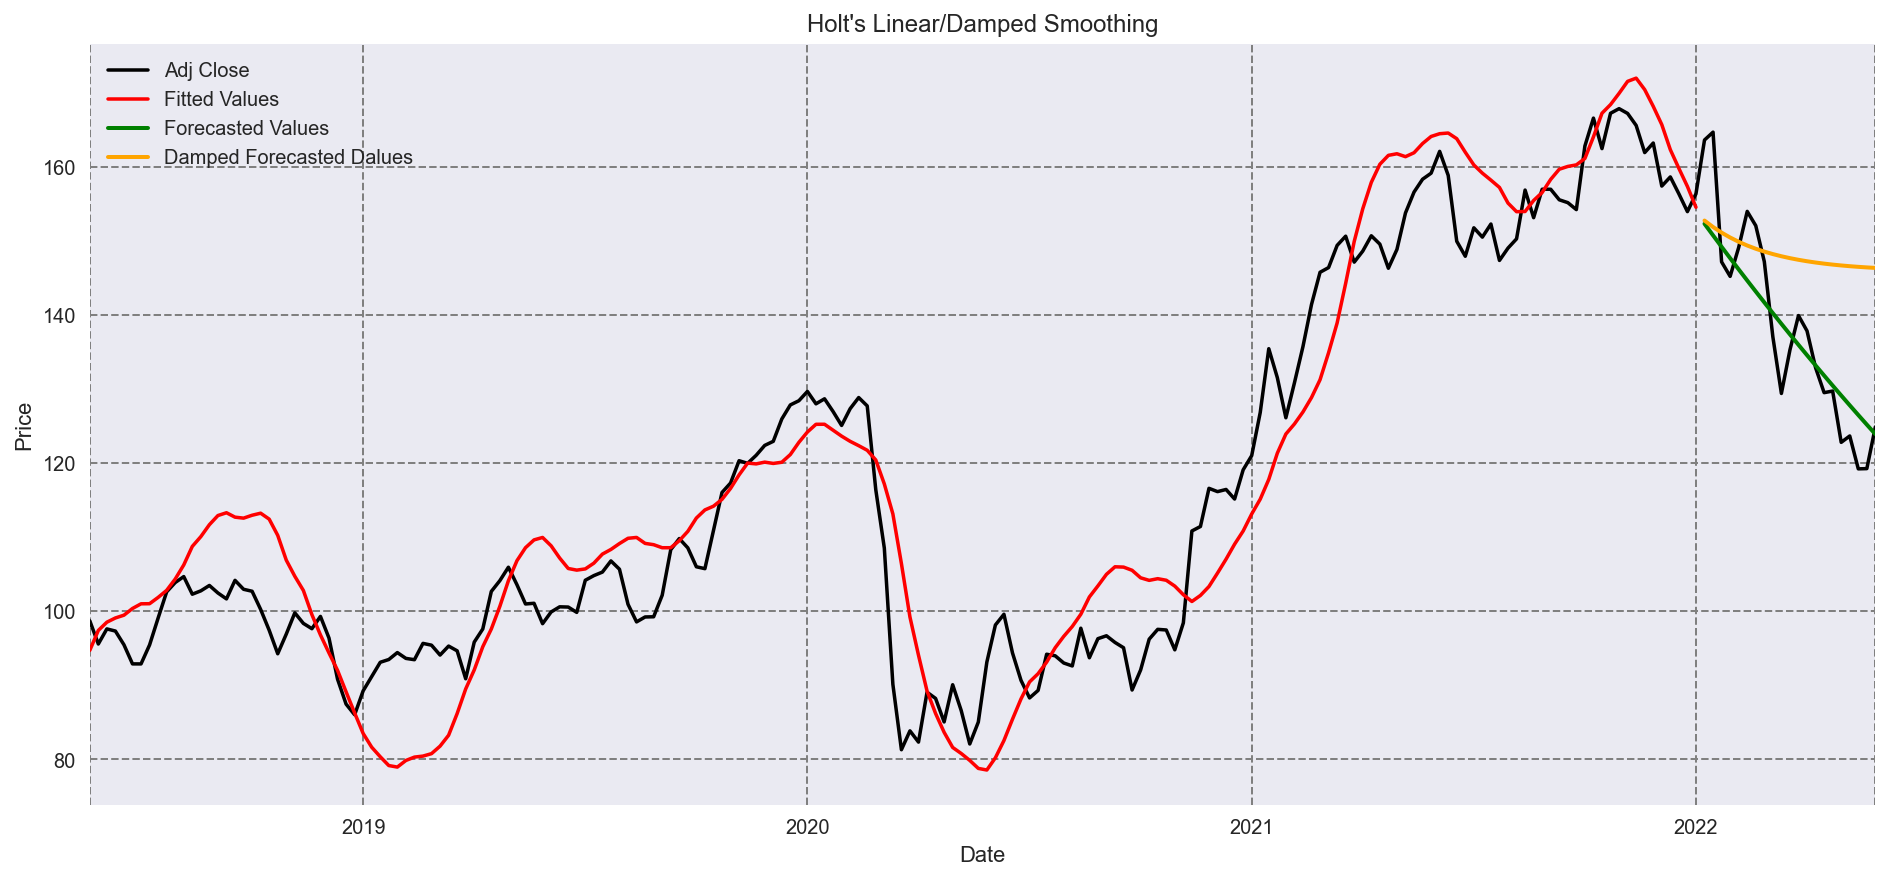

In [45]:
jpm_week_data.plot(color='k',
          title="Holt's Linear/Damped Smoothing",
          legend=True,figsize = (16,7))

model_1.fittedvalues.plot(color='r', label = 'Fitted Values', legend = True)
yhat_1.plot(color='g', legend=True, label='Forecasted Values', lw = 2.0)
yhat_2.plot(color = 'orange', legend = True, label = 'Damped Forecasted Dalues', lw = 2.0)



plt.ylabel('Price')
plt.grid(linestyle = '--', c = 'grey');

From the graph, we can see that the double exponential smoothing performed significantly better than simple exponential smoothing. Holt's Linear Smoothing performs better than when we add a damped parameter.

### Triple Exponencial Smoothing

In [46]:
seasonal_periods = 52
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(train_data_es, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods = seasonal_periods, damped = False).fit()
hw_forecast_1 = hw_1.forecast(len(test_data_es))

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(train_data_es, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=seasonal_periods, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(len(test_data_es))

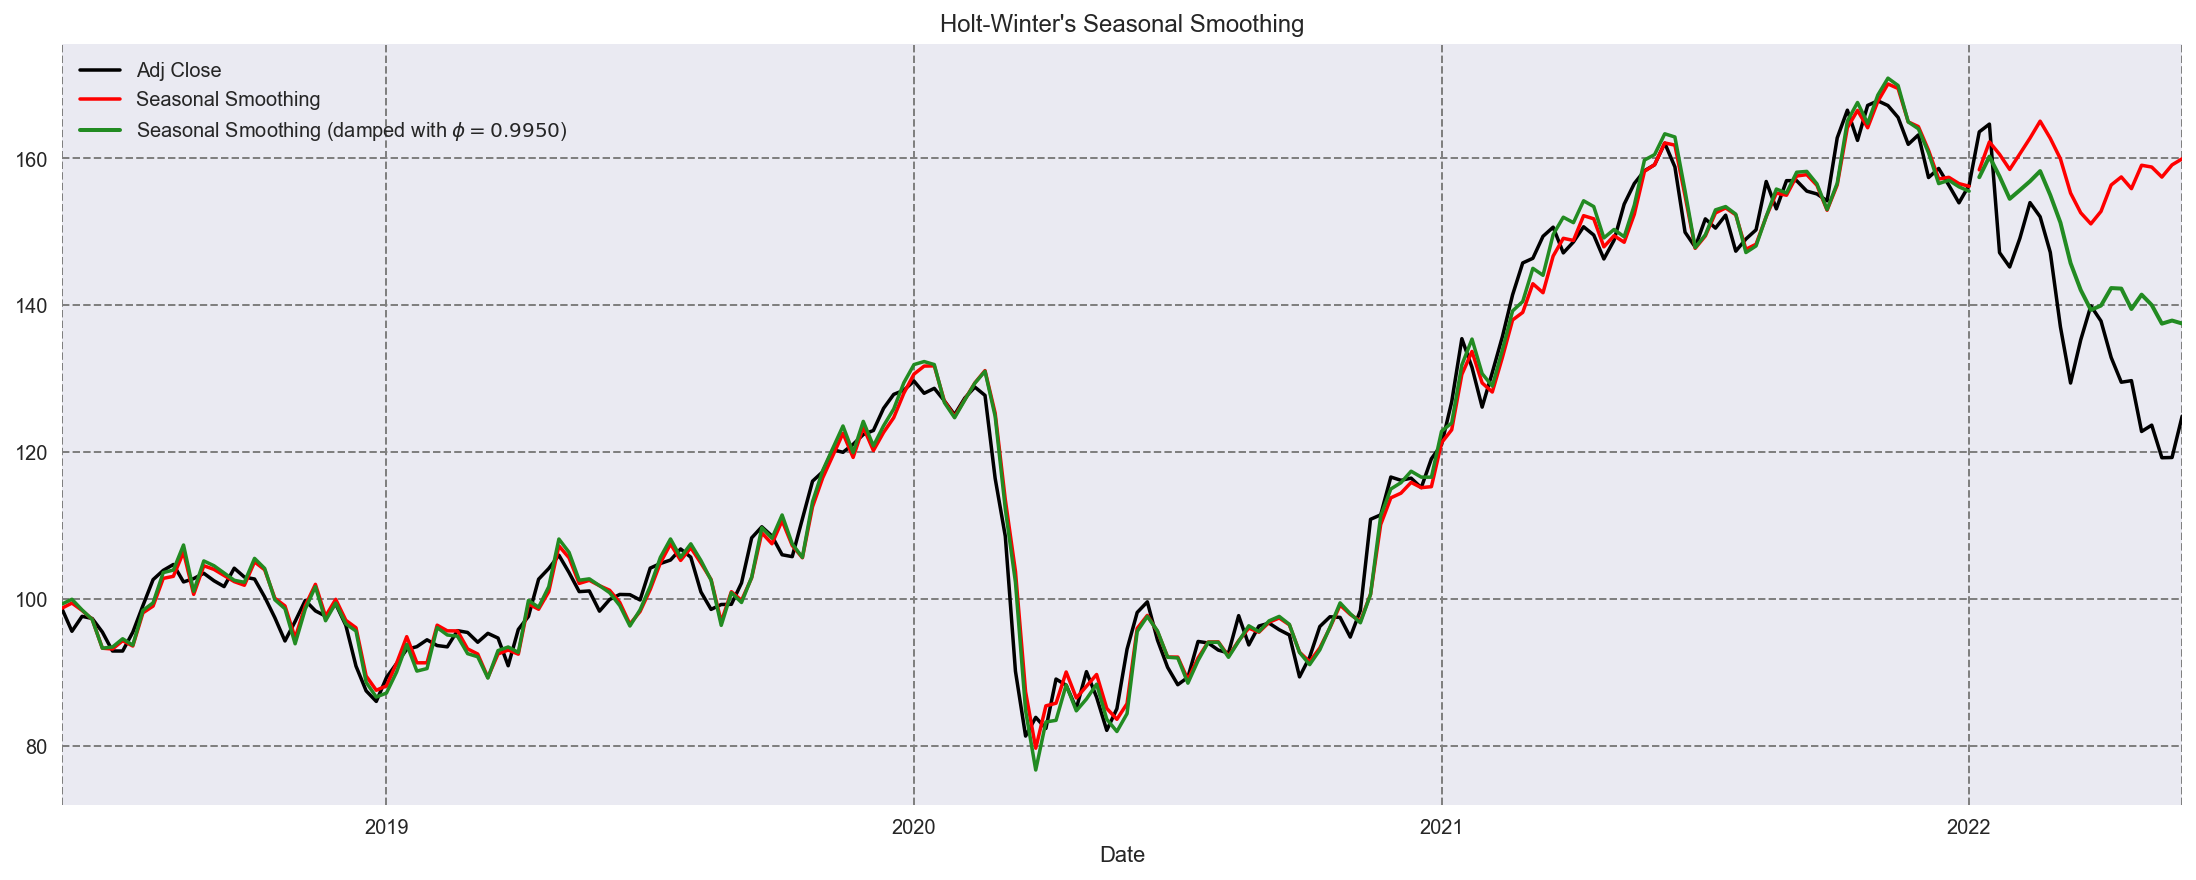

In [47]:
jpm_week_data.plot(color='k',
          title="Holt-Winter's Seasonal Smoothing",
          legend=True, figsize = (19,7))

hw_1.fittedvalues.plot(color='r')
hw_forecast_1.plot(color='r', legend=True, 
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_trend']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color='forestgreen')
hw_forecast_2.plot(color='forestgreen', legend=True, 
                   label=plot_label, lw = 2.0)
plt.grid(linestyle = '--', c = 'grey');

### ARIMA model 

In [48]:
#divide entire dataset into trainig and test dataset
train_data  = jpm_stock_data['Adj Close'].iloc[:int(jpm_stock_data['Adj Close'].shape[0]*0.90)].dropna()
test_data  = jpm_stock_data['Adj Close'].iloc[int(jpm_stock_data['Adj Close'].shape[0]*0.90):].dropna()
num_test_data = test_data.shape[0]
num_train_data = train_data.shape[0]


p,d,q parameters

* p: order of the autoregressive part;
* d: the number of times that the raw observations are differenced, also called the degree of differencing.
* q: order of the moving average part

### Moving Average

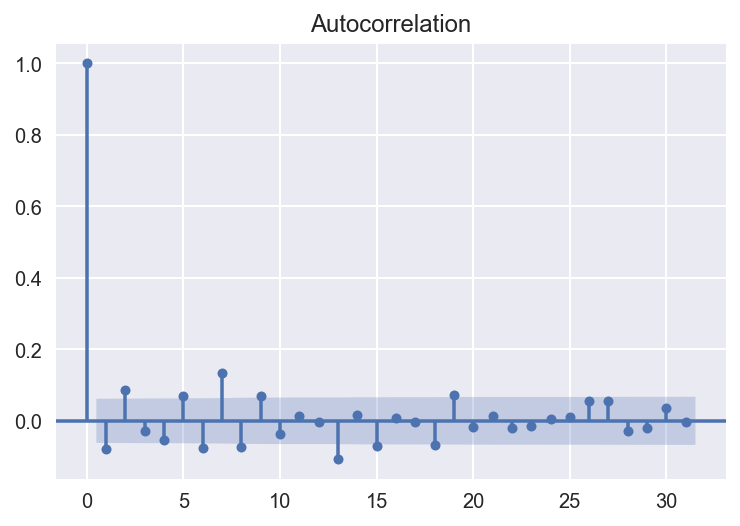

In [49]:
diff_data = jpm_stock_data['Adj Close'].diff(1)
plot_acf(diff_data.dropna());

In [50]:
moving_average_jpm=diff_data.dropna().rolling(window=13).mean()

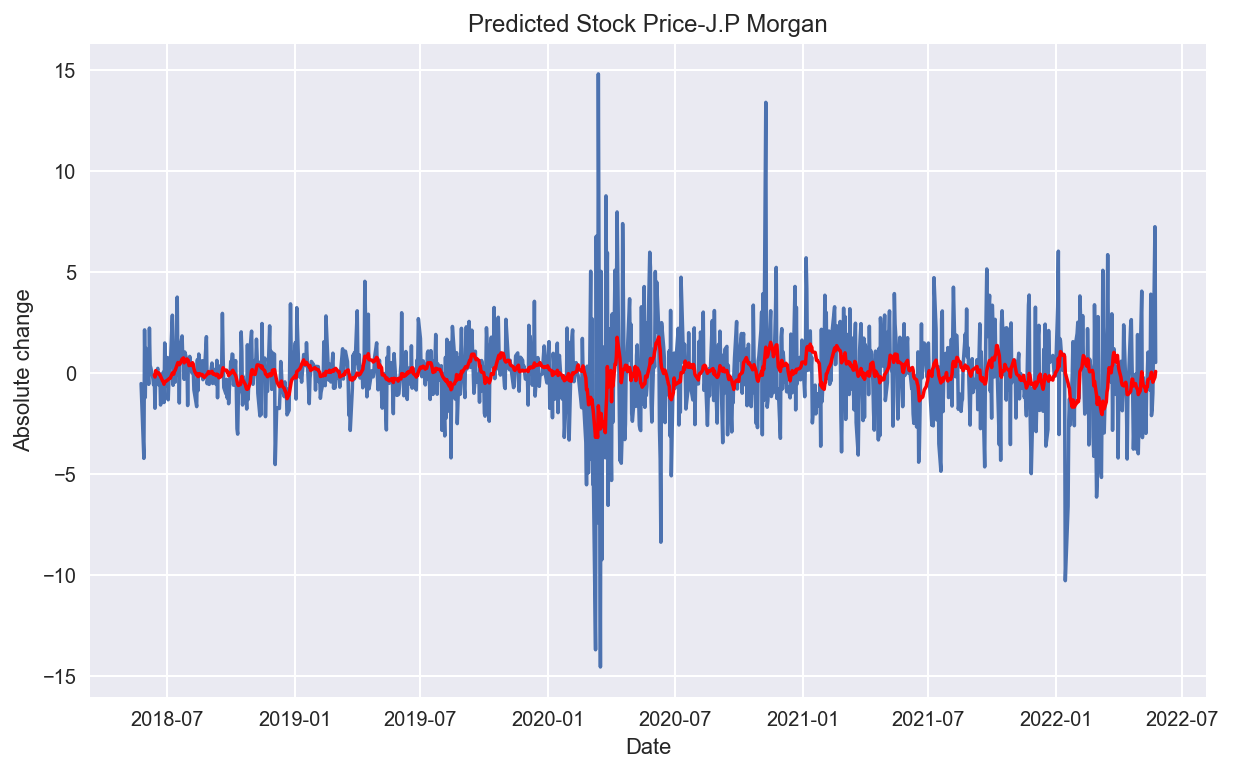

In [51]:
plt.figure(figsize=(10,6))
plt.plot(diff_data)
plt.plot(moving_average_jpm, c = 'r')
plt.title('Predicted Stock Price-J.P Morgan')
plt.xlabel('Date')
plt.ylabel(ylabel='Absolute change')
plt.show()
#We have actual values and predictions. The MA line mimics the trend of actual values
#but there is room for improvement because 
#the fluctuation of actual values is greater than those predicted.

### Modeling Time Series with auto ARIMA

In [52]:
#start_p -> the order of the auto-regressive (“AR”) model
#start_q-> the starting value of q, the order of the moving-average (“MA”) model.
#m -> the number of periods in each season
model = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3,
                   m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,
                   error_action='ignore',
                   test = 'adf',
                   information_criterion='aic',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4514.762, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4267.903, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4510.124, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4156.476, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4164.830, Time=0.38 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4144.424, Time=0.78 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4257.472, Time=0.32 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.96 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4142.099, Time=0.84 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4256.2

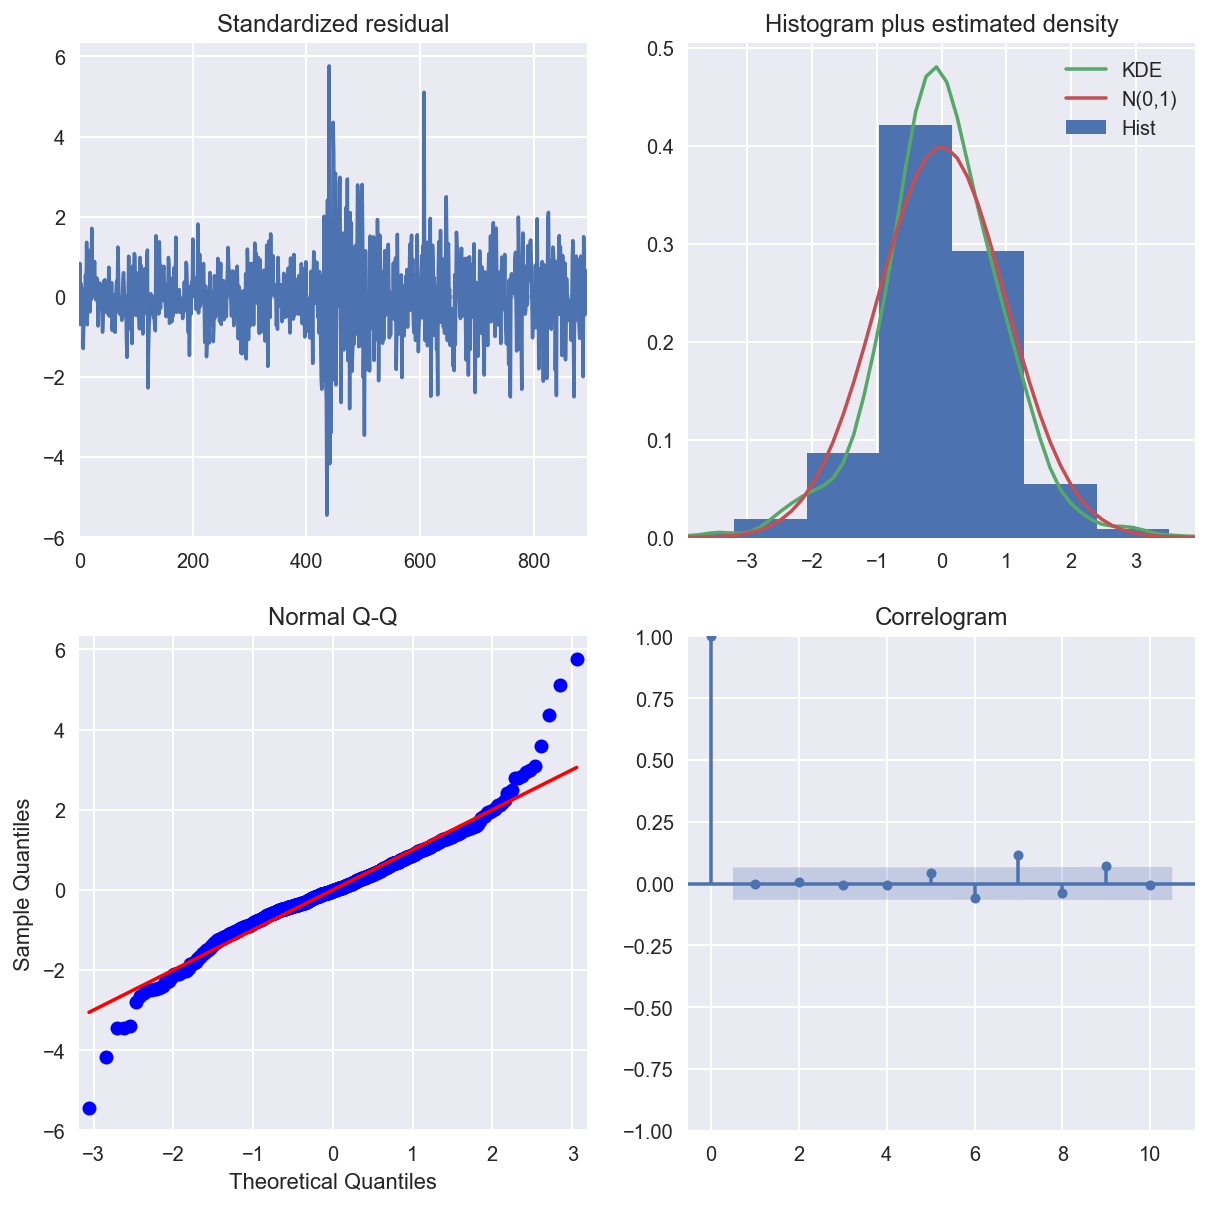

In [53]:
#residuals to check their normality 
output = model.plot_diagnostics(figsize=(10,10))

Notice how the normal Q-Q plot and the histogram show that our residuals follow a normal distribution. The correlogram also shows that the residuals are uncorrelated !

In [54]:
model.fit(train_data)

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [55]:
forecast = model.predict(num_test_data)

In [56]:
forecast = pd.DataFrame(forecast, index = test_data.index, columns = ['Prediction'])
test_data = pd.DataFrame(test_data, columns= ['Adj Close'])

In [57]:
rms = sqrt(mean_squared_error(test_data['Adj Close'], forecast['Prediction']))
print("RMSE: ", rms)

RMSE:  7.309428947776489


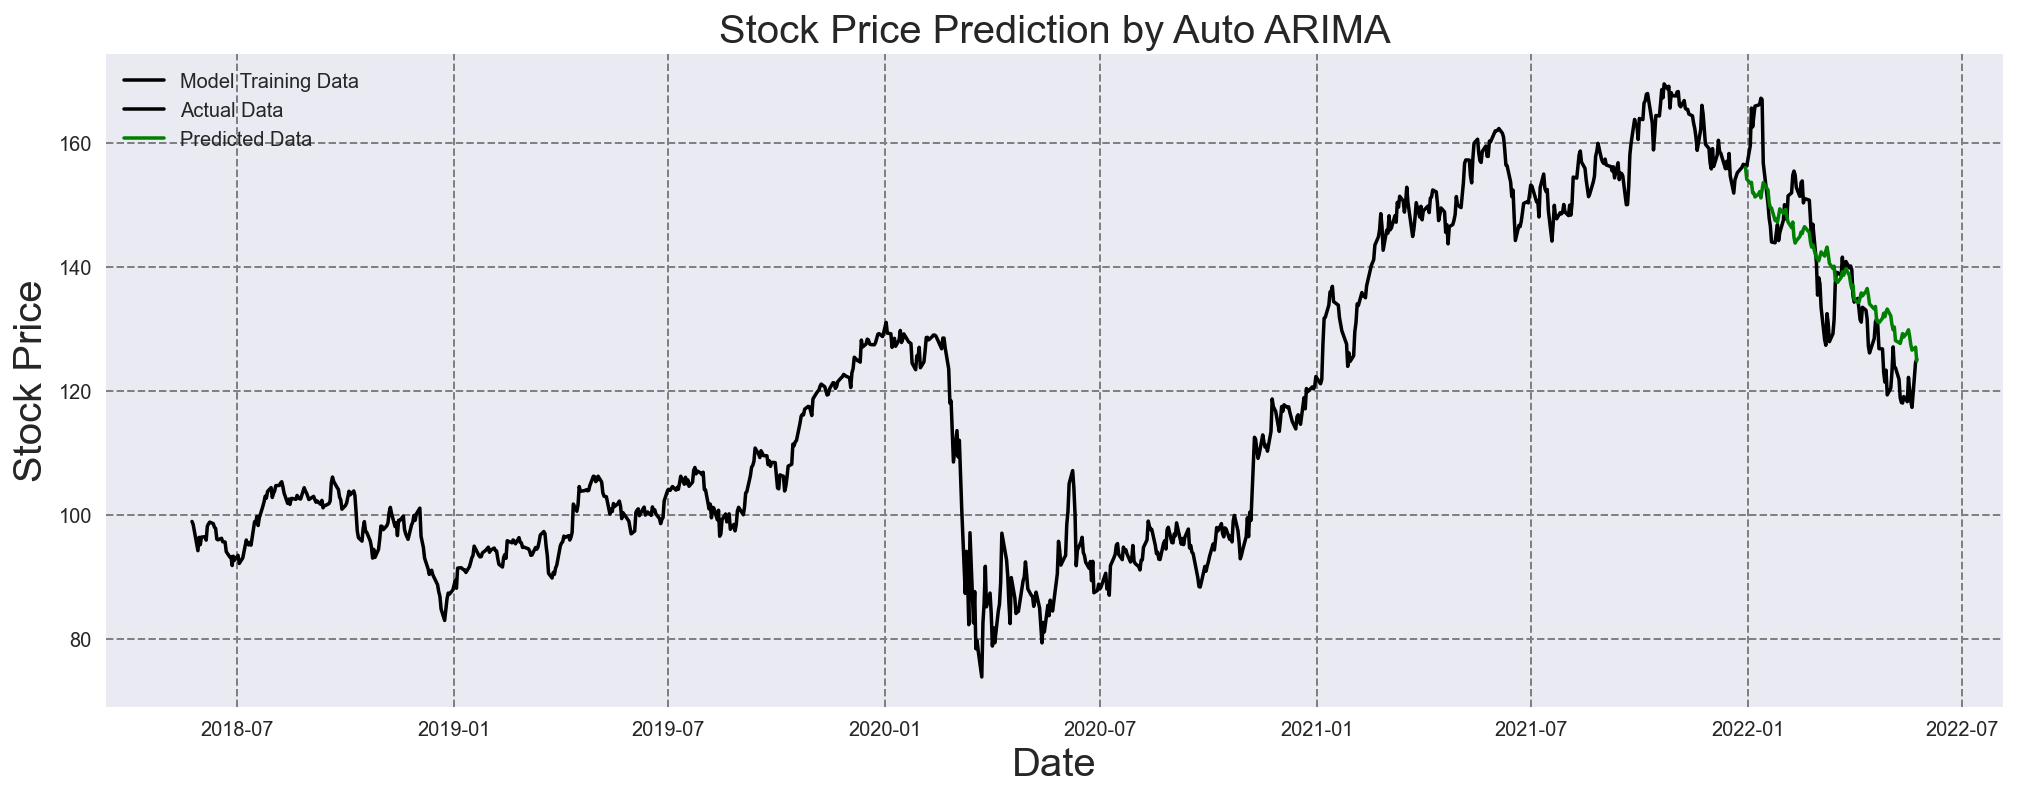

In [58]:
plt.figure(figsize = (17,6))
plt.plot(train_data, c = 'k')
plt.plot(test_data['Adj Close'], c = 'k')
plt.plot(forecast['Prediction'], c = 'g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Prediction by Auto ARIMA',size=20)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])
plt.grid(linestyle = '--', c = 'grey')


Now, I take all the historical data and make the price prediction for the next quarter.

In [59]:
model_2 = auto_arima(jpm_stock_data['Adj Close'],m= 12,seasonal=True,d=1, D=1,
                   error_action='ignore', suppress_warnings=True,stepwise=True, n_jobs=-1,random_state=20,random=True)

In [60]:
#create empty dataframe with future dates
future_dates = [jpm_stock_data.index[-1] + DateOffset(days=x) for x in range(0,90) ]
future_dates
df = pd.DataFrame(index = future_dates) # just dates
df.shape

(90, 0)

In [61]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1008
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2343.277
Date:                            Tue, 24 May 2022   AIC                           4702.555
Time:                                    18:24:52   BIC                           4741.777
Sample:                                         0   HQIC                          4717.465
                                           - 1008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0531      0.021     -2.484      0.013      -0.095      -0.011
ar.L2          0.0858      0.024      3.583      0.000       0.039       0.133
ar.L3         -0.0702      0.024     -2.982      0.003      -0.116      -0.024
ar.L4         -0.0700      0.020     -3.425      0.001      -0.110      -0.030
ar.L5          0.0496      0.023      2.188      0.029       0.005       0.094
ar.S.L12      -0.6824      0.022    -30.946      0.000      -0.726      -0.639
ar.S.L24      -0.3475      0.023    -14.902      0.000      -0.393      -0.302
sigma2         6.4591      0.179     36.166      0.000       6.109       6.809
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               557.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
forecast = model_2.predict(90) 
df['Forecast'] = forecast

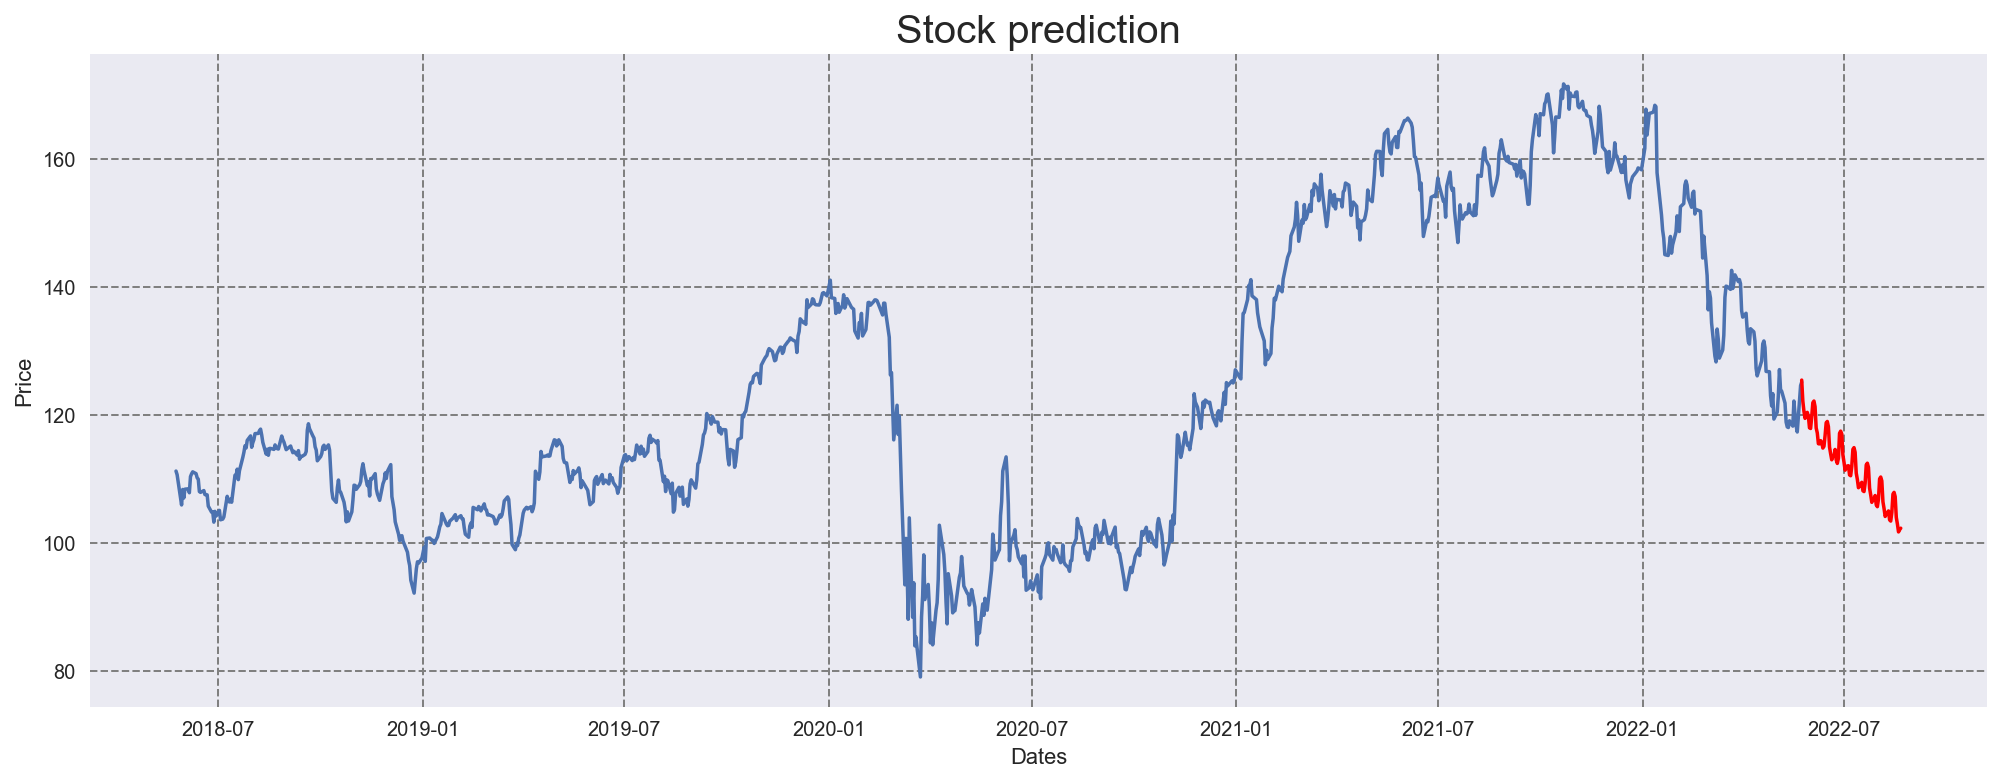

In [63]:
plt.figure(figsize = (17,6))
plt.plot(jpm_stock_data['Close'])
plt.plot(df['Forecast'], c = 'red')
plt.title('Stock prediction', fontdict={'fontsize': 20})
plt.ylabel('Price')
plt.xlabel('Dates')
plt.grid(linestyle = '--', c = 'grey')
plt.show()

### Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state
* The forget gate: It removes the information that is no longer required by the model
* The output gate: Output Gate at LSTM selects the information to be shown as output

In [64]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [65]:
#take data
dataset = jpm_stock_data['Close'].to_frame()
#create train and test data
train_data  = jpm_stock_data['Close'].iloc[:int(jpm_stock_data['Close'].shape[0]*0.90)].dropna().to_frame()
test_data  = jpm_stock_data['Close'].iloc[int(jpm_stock_data['Close'].shape[0]*0.90):].dropna().to_frame()

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [67]:
x_train, y_train = [], []
for i in range(60,len(train_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [68]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [74]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

847/847 - 20s - loss: 0.0052 - 20s/epoch - 23ms/step


In [70]:
#predicting values, using past 60 from the train data
inputs = dataset[len(dataset) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [71]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [72]:
rms=np.sqrt(np.mean(np.power((test_data-closing_price),2)))
rms

Close    5.521582
dtype: float64

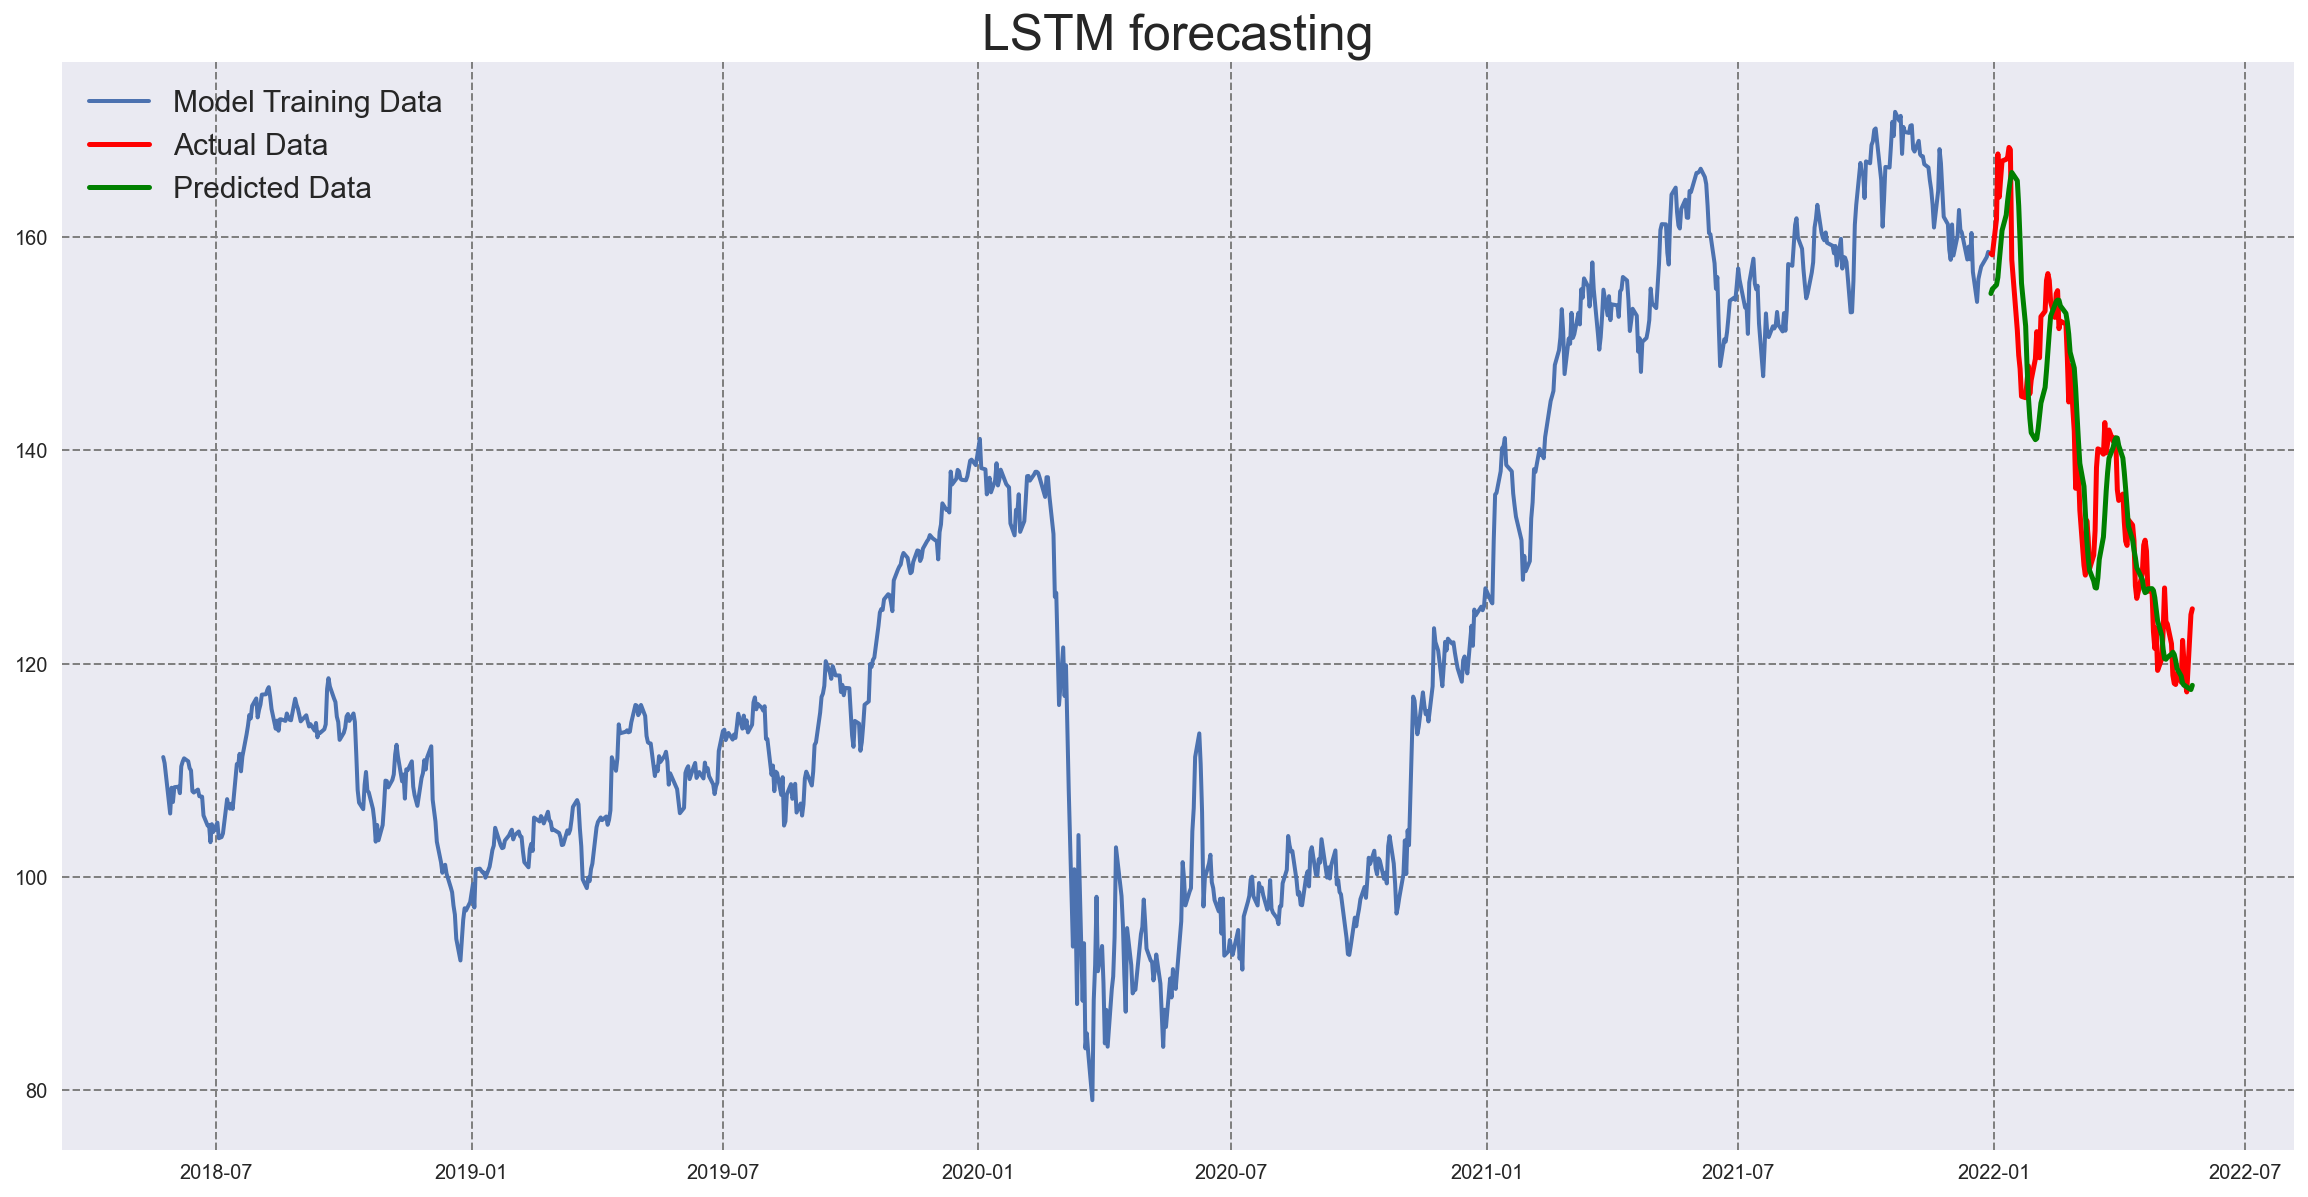

In [73]:
#plotting
test_data['Predictions'] = closing_price

plt.figure(figsize = (20,10))
plt.plot(train_data,lw = 2.0, label = 'Model Training Data')
plt.plot(test_data['Close'],lw = 2.5, label = 'Actual Data', c = 'r')
plt.plot(test_data['Predictions'],lw = 2.5, label = 'Predicted Data', c = 'g')
plt.title('LSTM forecasting', fontdict={'fontsize': 25})
plt.grid(linestyle = '--', c = 'grey')
plt.legend(loc = 'upper left', fontsize= 15)
plt.show()